# **Import Libraries**

In [1]:
%matplotlib inline
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from glob import glob 
import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sns
from skimage.util import montage as montage2d
from skimage.io import imread
import matplotlib.gridspec as gridspec
import matplotlib.ticker as ticker
sns.set_style('whitegrid')

# **Import Dataset**

In [2]:

all_xray_df = pd.read_csv('/content/drive/MyDrive/Data_Entry_2017_v2020.csv')
all_xray_df.sample(5)
all_image_paths =  glob('/content/drive/MyDrive/Images/image*/*.png')
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])

Scans found: 112120 , Total Headers 112120


In [3]:
img_paths = {os.path.basename(x): x for x in all_image_paths}
all_xray_df['path'] = all_xray_df['Image Index'].map(img_paths.get)
all_xray_df['Pneumonia'] = all_xray_df['Finding Labels'].map(lambda x: 'Pneumonia' in x)
all_xray_df['Patient Age'] = np.clip(all_xray_df['Patient Age'], 5, 100)
all_xray_df['Patient Male'] = all_xray_df['Patient Gender'].map(lambda x: x.upper()=='M').astype('float32')
all_xray_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],path,Pneumonia,Patient Male
24162,00006342_006.png,Infiltration,6,6342,53,M,PA,2992,2991,0.143000,0.143000,/content/drive/MyDrive/Images/image3/00006342_...,False,1.0
110921,00030250_000.png,No Finding,0,30250,45,F,PA,2021,2021,0.194311,0.194311,/content/drive/MyDrive/Images/image12/00030250...,False,0.0
68740,00016971_016.png,Effusion|Mass,16,16971,64,M,PA,2992,2991,0.143000,0.143000,/content/drive/MyDrive/Images/image8/00016971_...,False,1.0


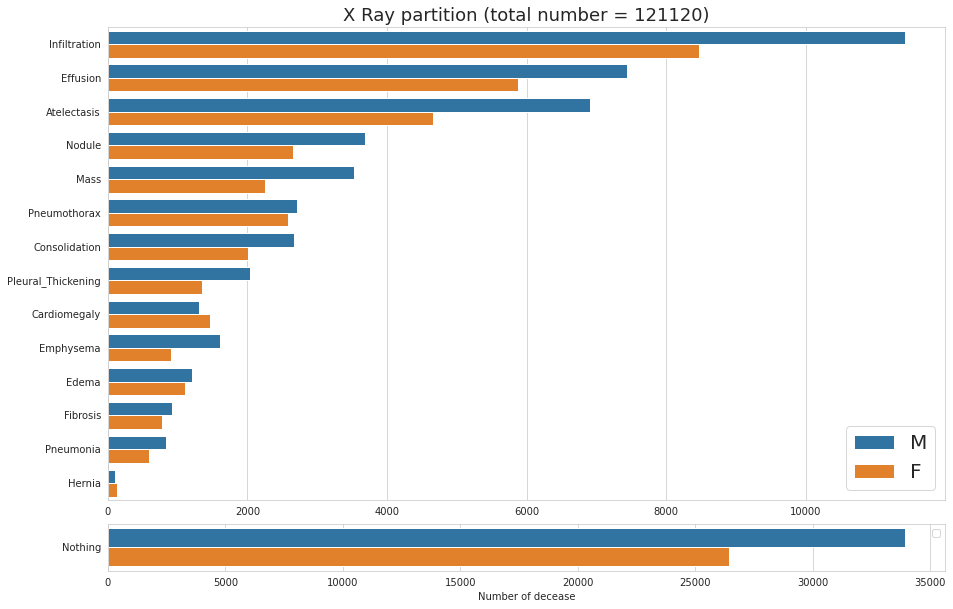

In [4]:
pathology_list = ['Cardiomegaly','Emphysema','Effusion','Hernia','Nodule','Pneumothorax','Atelectasis','Pleural_Thickening','Mass','Edema','Consolidation','Infiltration','Fibrosis','Pneumonia']
for pathology in pathology_list :
    all_xray_df[pathology] = all_xray_df['Finding Labels'].apply(lambda x: 1 if pathology in x else 0)
plt.figure(figsize=(15,10))
gs = gridspec.GridSpec(8,1)
ax1 = plt.subplot(gs[:7, :])
ax2 = plt.subplot(gs[7, :])
data1 = pd.melt(all_xray_df,
             id_vars=['Patient Gender'],
             value_vars = list(pathology_list),
             var_name = 'Category',
             value_name = 'Count')
data1 = data1.loc[data1.Count>0]
g=sns.countplot(y='Category',hue='Patient Gender',data=data1, ax=ax1, order = data1['Category'].value_counts().index)
ax1.set( ylabel="",xlabel="")
ax1.legend(fontsize=20)
ax1.set_title('X Ray partition (total number = 121120)',fontsize=18);

all_xray_df['Nothing']=all_xray_df['Finding Labels'].apply(lambda x: 1 if 'No Finding' in x else 0)

data2 = pd.melt(all_xray_df,
             id_vars=['Patient Gender'],
             value_vars = list(['Nothing']),
             var_name = 'Category',
             value_name = 'Count')
data2 = data2.loc[data2.Count>0]
g=sns.countplot(y='Category',hue='Patient Gender',data=data2,ax=ax2)
ax2.set( ylabel="",xlabel="Number of decease")
ax2.legend('')
plt.subplots_adjust(hspace=.5)
all_xray_df['Pneumonia'] = all_xray_df['Finding Labels'].map(lambda x: 'Pneumonia' in x)

## **NO FINDINGS**

1    60361
0    51759
Name: Nothing, dtype: int64


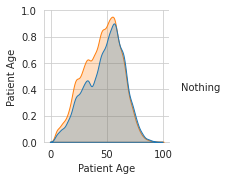

In [ ]:
positive_cases = np.sum(all_xray_df['Nothing']==True)//2
oversample_factor = 4 # maximum number of cases in negative group so it isn't super rare
more_balanced_df = all_xray_df.groupby(['Nothing']).apply(lambda x: x.sample(min(oversample_factor*positive_cases, x.shape[0]), 
                                                                                   replace = False)
                                                      ).reset_index(drop = True)

print(more_balanced_df['Nothing'].value_counts())
sns.pairplot(more_balanced_df[['Patient Age', 'Nothing']], hue='Nothing')

In [ ]:
from sklearn.model_selection import train_test_split
raw_train_df, test_valid_df = train_test_split(more_balanced_df, 
                                   test_size = 0.30, 
                                   random_state = 2018,
                                   stratify = more_balanced_df[['Nothing']])
valid_df, test_df = train_test_split(test_valid_df, 
                                   test_size = 0.40, 
                                   random_state = 2018,
                                   stratify = test_valid_df[['Nothing']])
print('train', raw_train_df.shape[0], 'validation', valid_df.shape[0], 'test', test_df.shape[0])
print('train', raw_train_df['Nothing'].value_counts())
print('test', test_df['Nothing'].value_counts())
raw_train_df.sample(1)

train 78484 validation 20181 test 13455
train 1    42253
0    36231
Name: Nothing, dtype: int64
test 1    7244
0    6211
Name: Nothing, dtype: int64


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],path,Pneumonia,Patient Male,Cardiomegaly,Emphysema,Effusion,Hernia,Nodule,Pneumothorax,Atelectasis,Pleural_Thickening,Mass,Edema,Consolidation,Infiltration,Fibrosis,Nothing
20332,00020922_002.png,Cardiomegaly|Consolidation|Effusion,0,20922,49,M,AP,3056,2544,0.139,0.139,/content/drive/MyDrive/Images/image9/00020922_...,False,1.0,1,0,1,0,0,0,0,0,0,0,1,0,0,0


# *Oversampling*

In [ ]:
train_df = raw_train_df.groupby(['Nothing']).apply(lambda x: x.sample(60000, replace = True)
                                                      ).reset_index(drop = True)
print('New Data Size:', train_df.shape[0], 'Old Size:', raw_train_df.shape[0])

New Data Size: 120000 Old Size: 78484


In [ ]:
from keras.preprocessing.image import ImageDataGenerator
idg = ImageDataGenerator(zoom_range=0.2,
                           fill_mode='nearest',
                           rotation_range=25,  
                           width_shift_range=0.25,  
                           height_shift_range=0.25,  
                           vertical_flip=False, 
                           horizontal_flip=True,
                           shear_range = 0.2,
                           samplewise_center=False, 
                           samplewise_std_normalization=False)


In [ ]:
SEED= 10
IMG_SIZE = (128, 128) 
####
def flow_from_dataframe(imgDatGen, df, batch_size, seed, img_size):
    #gc.collect()
    gen_img = imgDatGen.flow_from_dataframe(dataframe=more_balanced_df,
        x_col='path', y_col='Nothing',
        batch_size=batch_size, seed=seed, shuffle=True, class_mode='other',
        target_size=img_size, color_mode='grayscale',
        drop_duplicates=False)

    
        
    while True:
        X1i = gen_img.next()
        #X2i = gen_img.next()
        #gc.collect()
        yield [X1i[0], X1i[1]]

In [ ]:
flow = flow_from_dataframe(idg, more_balanced_df, 7151, SEED, IMG_SIZE)

In [ ]:
t,y= next(flow)

--- Logging error ---
Traceback (most recent call last):
  File "/usr/lib/python3.7/logging/__init__.py", line 1025, in emit
    msg = self.format(record)
  File "/usr/lib/python3.7/logging/__init__.py", line 869, in format
    return fmt.format(record)
  File "/usr/lib/python3.7/logging/__init__.py", line 608, in format
    record.message = record.getMessage()
  File "/usr/lib/python3.7/logging/__init__.py", line 369, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "/usr/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.7/dist-packages/traitlets/config/application.py", line 846, in launch_instance
    app.start()
  File "/usr/local/lib/pytho

Found 112120 validated image filenames.


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(t,y, 
                                   test_size = 0.30, 
                                   random_state = 2018)


# **TRAIN MODEL**

In [ ]:
from keras.applications.mobilenet import MobileNet
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from keras.models import Sequential
mobilenet_model = MobileNet(input_shape =  X_train.shape[1:], 
                                 include_top = False, weights = None)
mobilenet_GAP_model = Sequential()
mobilenet_GAP_model.add(mobilenet_model)
mobilenet_GAP_model.add(GlobalAveragePooling2D())
mobilenet_GAP_model.add(Dropout(0.5))
mobilenet_GAP_model.add(Dense(512))
mobilenet_GAP_model.add(Dropout(0.5))
mobilenet_GAP_model.add(Dense(1, activation = 'sigmoid'))
mobilenet_GAP_model.compile(optimizer = 'adam', loss = 'binary_crossentropy',
                           metrics = ['binary_accuracy', 'mae'])
mobilenet_GAP_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_128 (Functio  (None, 4, 4, 1024)       3228288   
 nal)                                                            
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 512)               524800    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 5

In [ ]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=3)
callbacks_list = [checkpoint, early]

In [ ]:
history_mobilenet_GAP = mobilenet_GAP_model.fit(X_train,y_train,
                                  steps_per_epoch=10,
                                  validation_data = (X_test, y_test), 
                                  epochs = 10, 
                                  callbacks = callbacks_list)

Epoch 1/10
10/10 [==============================] - ETA: 0s - loss: 2.1242 - binary_accuracy: 0.4967 - mae: 0.5022 
Epoch 00001: val_loss improved from inf to 0.69779, saving model to xray_class_weights.best.hdf5
10/10 [==============================] - 300s 29s/step - loss: 2.1242 - binary_accuracy: 0.4967 - mae: 0.5022 - val_loss: 0.6978 - val_binary_accuracy: 0.4562 - val_mae: 0.5019
Epoch 2/10
10/10 [==============================] - ETA: 0s - loss: 1.0295 - binary_accuracy: 0.5033 - mae: 0.4986 
Epoch 00002: val_loss improved from 0.69779 to 0.69064, saving model to xray_class_weights.best.hdf5
10/10 [==============================] - 288s 29s/step - loss: 1.0295 - binary_accuracy: 0.5033 - mae: 0.4986 - val_loss: 0.6906 - val_binary_accuracy: 0.5438 - val_mae: 0.4984
Epoch 3/10
10/10 [==============================] - ETA: 0s - loss: 0.8487 - binary_accuracy: 0.4909 - mae: 0.5053 
Epoch 00003: val_loss improved from 0.69064 to 0.68980, saving model to xray_class_weights.best.hdf5

In [ ]:
pred_Y = mobilenet_GAP_model.predict(X_test, 
                          batch_size = 32, 
                          verbose = True)

68/68 [==============================] - 24s 344ms/step


In [ ]:
pred_Y

array([[0.5343948],
       [0.5343948],
       [0.5343948],
       ...,
       [0.5343948],
       [0.5343948],
       [0.5343948]], dtype=float32)

In [ ]:
min(pred_Y)

array([0.5343948], dtype=float32)

# **Accuracy**

In [ ]:
print('test accuracy = ',mobilenet_GAP_model.evaluate(X_test,y_test, verbose=0)[1])

test accuracy =  0.5438024401664734


In [ ]:
from sklearn.metrics import roc_auc_score
print('roc score = ',roc_auc_score(y_test.astype(int), pred_Y))

roc score =  0.5


# **Classification Report**

              precision    recall  f1-score   support

    Findings       0.00      0.00      0.00       979
 No Findings       0.54      1.00      0.70      1167

    accuracy                           0.54      2146
   macro avg       0.27      0.50      0.35      2146
weighted avg       0.30      0.54      0.38      2146



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


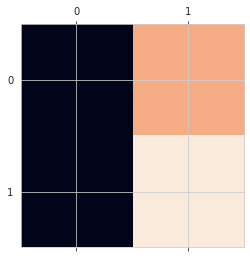

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
plt.matshow(confusion_matrix(y_test, pred_Y>0.5343945))
print(classification_report(y_test, pred_Y>0.5343945, target_names = ['Findings', 'No Findings']))

## **Atelectasis**

0    23116
1    11559
Name: Atelectasis, dtype: int64


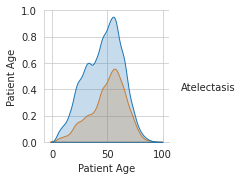

In [ ]:
positive_cases = np.sum(all_xray_df['Atelectasis']==True)//2
oversample_factor = 4 # maximum number of cases in negative group so it isn't super rare
more_balanced_df = all_xray_df.groupby(['Atelectasis']).apply(lambda x: x.sample(min(oversample_factor*positive_cases, x.shape[0]), 
                                                                                   replace = False)
                                                      ).reset_index(drop = True)

print(more_balanced_df['Atelectasis'].value_counts())
sns.pairplot(more_balanced_df[['Patient Age', 'Atelectasis']], hue='Atelectasis')

In [ ]:
from sklearn.model_selection import train_test_split
raw_train_df, test_valid_df = train_test_split(more_balanced_df, 
                                   test_size = 0.30, 
                                   random_state = 2018,
                                   stratify = more_balanced_df[['Atelectasis']])
valid_df, test_df = train_test_split(test_valid_df, 
                                   test_size = 0.40, 
                                   random_state = 2018,
                                   stratify = test_valid_df[['Atelectasis']])
print('train', raw_train_df.shape[0], 'validation', valid_df.shape[0], 'test', test_df.shape[0])
print('train', raw_train_df['Atelectasis'].value_counts())
print('test', test_df['Atelectasis'].value_counts())
raw_train_df.sample(1)

train 24272 validation 6241 test 4162
train 0    16181
1     8091
Name: Atelectasis, dtype: int64
test 0    2775
1    1387
Name: Atelectasis, dtype: int64


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],path,Pneumonia,Patient Male,Cardiomegaly,Emphysema,Effusion,Hernia,Nodule,Pneumothorax,Atelectasis,Pleural_Thickening,Mass,Edema,Consolidation,Infiltration,Fibrosis,Nothing
4259,00019124_127.png,No Finding,56,19124,51,F,PA,2582,2991,0.143,0.143,/content/drive/MyDrive/Images/image9/00019124_...,False,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


# *Oversampling*

In [ ]:
train_df = raw_train_df.groupby(['Atelectasis']).apply(lambda x: x.sample(60000, replace = True)
                                                      ).reset_index(drop = True)
print('New Data Size:', train_df.shape[0], 'Old Size:', raw_train_df.shape[0])

New Data Size: 120000 Old Size: 24272


In [ ]:
from keras.preprocessing.image import ImageDataGenerator
idg = ImageDataGenerator(zoom_range=0.2,
                           fill_mode='nearest',
                           rotation_range=25,  
                           width_shift_range=0.25,  
                           height_shift_range=0.25,  
                           vertical_flip=False, 
                           horizontal_flip=True,
                           shear_range = 0.2,
                           samplewise_center=False, 
                           samplewise_std_normalization=False)


In [ ]:
SEED= 10
IMG_SIZE = (128, 128) 
####
def flow_from_dataframe(imgDatGen, df, batch_size, seed, img_size):
    #gc.collect()
    gen_img = imgDatGen.flow_from_dataframe(dataframe=more_balanced_df,
        x_col='path', y_col='Atelectasis',
        batch_size=batch_size, seed=seed, shuffle=True, class_mode='other',
        target_size=img_size, color_mode='grayscale',
        drop_duplicates=False)

    
        
    while True:
        X1i = gen_img.next()
        #X2i = gen_img.next()
        #gc.collect()
        yield [X1i[0], X1i[1]]

In [ ]:
flow = flow_from_dataframe(idg, more_balanced_df, 7151, SEED, IMG_SIZE)

In [ ]:
t,y= next(flow)

--- Logging error ---
Traceback (most recent call last):
  File "/usr/lib/python3.7/logging/__init__.py", line 1025, in emit
    msg = self.format(record)
  File "/usr/lib/python3.7/logging/__init__.py", line 869, in format
    return fmt.format(record)
  File "/usr/lib/python3.7/logging/__init__.py", line 608, in format
    record.message = record.getMessage()
  File "/usr/lib/python3.7/logging/__init__.py", line 369, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "/usr/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.7/dist-packages/traitlets/config/application.py", line 846, in launch_instance
    app.start()
  File "/usr/local/lib/pytho

Found 34675 validated image filenames.


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(t,y, 
                                   test_size = 0.30, 
                                   random_state = 2018)


In [ ]:
from keras.applications.mobilenet import MobileNet
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from keras.models import Sequential
mobilenet_model = MobileNet(input_shape =  X_train.shape[1:], 
                                 include_top = False, weights = None)
mobilenet_GAP_model = Sequential()
mobilenet_GAP_model.add(mobilenet_model)
mobilenet_GAP_model.add(GlobalAveragePooling2D())
mobilenet_GAP_model.add(Dropout(0.5))
mobilenet_GAP_model.add(Dense(512))
mobilenet_GAP_model.add(Dropout(0.5))
mobilenet_GAP_model.add(Dense(1, activation = 'sigmoid'))
mobilenet_GAP_model.compile(optimizer = 'adam', loss = 'binary_crossentropy',
                           metrics = ['binary_accuracy', 'mae'])
mobilenet_GAP_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_128 (Functio  (None, 4, 4, 1024)       3228288   
 nal)                                                            
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 512)               524800    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 5

In [ ]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=3)
callbacks_list = [checkpoint, early]

In [ ]:
history_mobilenet_GAP = mobilenet_GAP_model.fit(X_train,y_train,
                                  steps_per_epoch=10,
                                  validation_data = (X_test, y_test), 
                                  epochs = 10, 
                                  callbacks = callbacks_list)

Epoch 1/10
10/10 [==============================] - ETA: 0s - loss: 1.4650 - binary_accuracy: 0.5504 - mae: 0.4487 
Epoch 00001: val_loss improved from inf to 0.69147, saving model to xray_class_weights.best.hdf5
10/10 [==============================] - 373s 37s/step - loss: 1.4650 - binary_accuracy: 0.5504 - mae: 0.4487 - val_loss: 0.6915 - val_binary_accuracy: 0.6794 - val_mae: 0.4992
Epoch 2/10
10/10 [==============================] - ETA: 0s - loss: 0.8493 - binary_accuracy: 0.5918 - mae: 0.4320 
Epoch 00002: val_loss improved from 0.69147 to 0.67860, saving model to xray_class_weights.best.hdf5
10/10 [==============================] - 367s 37s/step - loss: 0.8493 - binary_accuracy: 0.5918 - mae: 0.4320 - val_loss: 0.6786 - val_binary_accuracy: 0.6794 - val_mae: 0.4923
Epoch 3/10
10/10 [==============================] - ETA: 0s - loss: 0.7420 - binary_accuracy: 0.6068 - mae: 0.4379 
Epoch 00003: val_loss did not improve from 0.67860
10/10 [==============================] - 361s 36s

In [ ]:
pred_Y = mobilenet_GAP_model.predict(X_test, 
                          batch_size = 32, 
                          verbose = True)

68/68 [==============================] - 24s 346ms/step


In [ ]:
pred_Y

array([[0.31119406],
       [0.31119406],
       [0.31119406],
       ...,
       [0.31119406],
       [0.31119406],
       [0.31119406]], dtype=float32)

In [ ]:
min(pred_Y)

array([0.31119406], dtype=float32)

In [ ]:
print('test accuracy = ',mobilenet_GAP_model.evaluate(X_test,y_test, verbose=0)[1])

test accuracy =  0.67940354347229


In [ ]:
from sklearn.metrics import roc_auc_score
print('roc score = ',roc_auc_score(y_test.astype(int), pred_Y))

roc score =  0.4994776214629789


                precision    recall  f1-score   support

No Atelectasis       0.68      0.99      0.81      1458
   Atelectasis       0.29      0.01      0.01       688

      accuracy                           0.68      2146
     macro avg       0.48      0.50      0.41      2146
  weighted avg       0.55      0.68      0.55      2146



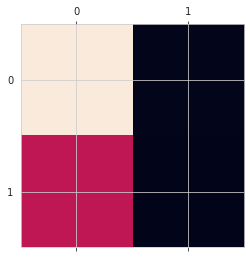

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
plt.matshow(confusion_matrix(y_test, pred_Y>0.31119406))
print(classification_report(y_test, pred_Y>0.31119406, target_names = ['No Atelectasis', 'Atelectasis']))

## **Cardiomegaly**

0    5552
1    2776
Name: Cardiomegaly, dtype: int64


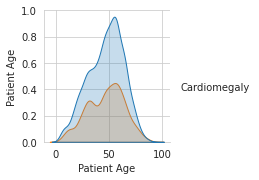

In [ ]:
positive_cases = np.sum(all_xray_df['Cardiomegaly']==True)//2
oversample_factor = 4 # maximum number of cases in negative group so it isn't super rare
more_balanced_df = all_xray_df.groupby(['Cardiomegaly']).apply(lambda x: x.sample(min(oversample_factor*positive_cases, x.shape[0]), 
                                                                                   replace = False)
                                                      ).reset_index(drop = True)

print(more_balanced_df['Cardiomegaly'].value_counts())
sns.pairplot(more_balanced_df[['Patient Age', 'Cardiomegaly']], hue='Cardiomegaly')

In [ ]:
from sklearn.model_selection import train_test_split
raw_train_df, test_valid_df = train_test_split(more_balanced_df, 
                                   test_size = 0.30, 
                                   random_state = 2018,
                                   stratify = more_balanced_df[['Cardiomegaly']])
valid_df, test_df = train_test_split(test_valid_df, 
                                   test_size = 0.40, 
                                   random_state = 2018,
                                   stratify = test_valid_df[['Cardiomegaly']])
print('train', raw_train_df.shape[0], 'validation', valid_df.shape[0], 'test', test_df.shape[0])
print('train', raw_train_df['Cardiomegaly'].value_counts())
print('test', test_df['Cardiomegaly'].value_counts())
raw_train_df.sample(1)

train 5829 validation 1499 test 1000
train 0    3886
1    1943
Name: Cardiomegaly, dtype: int64
test 0    667
1    333
Name: Cardiomegaly, dtype: int64


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],path,Pneumonia,Patient Male,Cardiomegaly,Emphysema,Effusion,Hernia,Nodule,Pneumothorax,Atelectasis,Pleural_Thickening,Mass,Edema,Consolidation,Infiltration,Fibrosis,Nothing
6680,00009717_002.png,Cardiomegaly,2,9717,48,M,PA,2992,2991,0.143,0.143,/content/drive/MyDrive/Images/image5/00009717_...,False,1.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


# *Oversampling*

In [ ]:
train_df = raw_train_df.groupby(['Cardiomegaly']).apply(lambda x: x.sample(60000, replace = True)
                                                      ).reset_index(drop = True)
print('New Data Size:', train_df.shape[0], 'Old Size:', raw_train_df.shape[0])

New Data Size: 120000 Old Size: 5829


In [ ]:
from keras.preprocessing.image import ImageDataGenerator
idg = ImageDataGenerator(zoom_range=0.2,
                           fill_mode='nearest',
                           rotation_range=25,  
                           width_shift_range=0.25,  
                           height_shift_range=0.25,  
                           vertical_flip=False, 
                           horizontal_flip=True,
                           shear_range = 0.2,
                           samplewise_center=False, 
                           samplewise_std_normalization=False)


In [ ]:
SEED= 10
IMG_SIZE = (128, 128) 
####
def flow_from_dataframe(imgDatGen, df, batch_size, seed, img_size):
    #gc.collect()
    gen_img = imgDatGen.flow_from_dataframe(dataframe=more_balanced_df,
        x_col='path', y_col='Cardiomegaly',
        batch_size=batch_size, seed=seed, shuffle=True, class_mode='other',
        target_size=img_size, color_mode='grayscale',
        drop_duplicates=False)

    
        
    while True:
        X1i = gen_img.next()
        #X2i = gen_img.next()
        #gc.collect()
        yield [X1i[0], X1i[1]]

In [ ]:
flow = flow_from_dataframe(idg, more_balanced_df, 7151, SEED, IMG_SIZE)

In [ ]:
t,y= next(flow)

--- Logging error ---
Traceback (most recent call last):
  File "/usr/lib/python3.7/logging/__init__.py", line 1025, in emit
    msg = self.format(record)
  File "/usr/lib/python3.7/logging/__init__.py", line 869, in format
    return fmt.format(record)
  File "/usr/lib/python3.7/logging/__init__.py", line 608, in format
    record.message = record.getMessage()
  File "/usr/lib/python3.7/logging/__init__.py", line 369, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "/usr/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.7/dist-packages/traitlets/config/application.py", line 846, in launch_instance
    app.start()
  File "/usr/local/lib/pytho

Found 8328 validated image filenames.


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(t,y, 
                                   test_size = 0.30, 
                                   random_state = 2018)


In [ ]:
from keras.applications.mobilenet import MobileNet
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from keras.models import Sequential
mobilenet_model = MobileNet(input_shape =  X_train.shape[1:], 
                                 include_top = False, weights = None)
mobilenet_GAP_model = Sequential()
mobilenet_GAP_model.add(mobilenet_model)
mobilenet_GAP_model.add(GlobalAveragePooling2D())
mobilenet_GAP_model.add(Dropout(0.5))
mobilenet_GAP_model.add(Dense(512))
mobilenet_GAP_model.add(Dropout(0.5))
mobilenet_GAP_model.add(Dense(1, activation = 'sigmoid'))
mobilenet_GAP_model.compile(optimizer = 'adam', loss = 'binary_crossentropy',
                           metrics = ['binary_accuracy', 'mae'])
mobilenet_GAP_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_128 (Functio  (None, 4, 4, 1024)       3228288   
 nal)                                                            
                                                                 
 global_average_pooling2d_1   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_2 (Dropout)         (None, 1024)              0         
                                                                 
 dense_2 (Dense)             (None, 512)               524800    
                                                                 
 dropout_3 (Dropout)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                

In [ ]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=3)
callbacks_list = [checkpoint, early]

In [ ]:
history_mobilenet_GAP = mobilenet_GAP_model.fit(X_train,y_train,
                                  steps_per_epoch=10,
                                  validation_data = (X_test, y_test), 
                                  epochs = 10, 
                                  callbacks = callbacks_list)

Epoch 1/10
10/10 [==============================] - ETA: 0s - loss: 1.4681 - binary_accuracy: 0.5874 - mae: 0.4212 
Epoch 00001: val_loss improved from inf to 0.69755, saving model to xray_class_weights.best.hdf5
10/10 [==============================] - 380s 38s/step - loss: 1.4681 - binary_accuracy: 0.5874 - mae: 0.4212 - val_loss: 0.6975 - val_binary_accuracy: 0.3453 - val_mae: 0.5022
Epoch 2/10
10/10 [==============================] - ETA: 0s - loss: 0.8863 - binary_accuracy: 0.5680 - mae: 0.4478 
Epoch 00002: val_loss improved from 0.69755 to 0.69067, saving model to xray_class_weights.best.hdf5
10/10 [==============================] - 361s 36s/step - loss: 0.8863 - binary_accuracy: 0.5680 - mae: 0.4478 - val_loss: 0.6907 - val_binary_accuracy: 0.6547 - val_mae: 0.4987
Epoch 3/10
10/10 [==============================] - ETA: 0s - loss: 0.7849 - binary_accuracy: 0.6224 - mae: 0.4260 
Epoch 00003: val_loss improved from 0.69067 to 0.68296, saving model to xray_class_weights.best.hdf5

In [ ]:
pred_Y = mobilenet_GAP_model.predict(X_test, 
                          batch_size = 32, 
                          verbose = True)

68/68 [==============================] - 24s 349ms/step


In [ ]:
pred_Y

array([[0.32580483],
       [0.32580483],
       [0.32580483],
       ...,
       [0.32580483],
       [0.32580483],
       [0.32580483]], dtype=float32)

In [ ]:
min(pred_Y)

array([0.32580477], dtype=float32)

In [ ]:
print('test accuracy = ',mobilenet_GAP_model.evaluate(X_test,y_test, verbose=0)[1])

test accuracy =  0.6547064185142517


In [ ]:
from sklearn.metrics import roc_auc_score
print('roc score = ',roc_auc_score(y_test.astype(int), pred_Y))

roc score =  0.5


                 precision    recall  f1-score   support

No Cardiomegaly       0.64      0.05      0.09      1405
   Cardiomegaly       0.34      0.95      0.51       741

       accuracy                           0.36      2146
      macro avg       0.49      0.50      0.30      2146
   weighted avg       0.54      0.36      0.24      2146



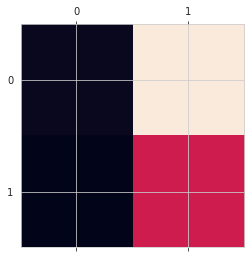

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
plt.matshow(confusion_matrix(y_test, pred_Y>0.32580477))
print(classification_report(y_test, pred_Y>0.32580477, target_names = ['No Cardiomegaly', 'Cardiomegaly']))

## **Consolidation**

0    9332
1    4667
Name: Consolidation, dtype: int64


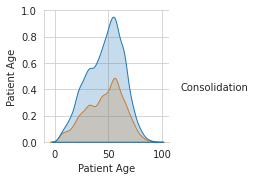

In [ ]:
positive_cases = np.sum(all_xray_df['Consolidation']==True)//2
oversample_factor = 4 # maximum number of cases in negative group so it isn't super rare
more_balanced_df = all_xray_df.groupby(['Consolidation']).apply(lambda x: x.sample(min(oversample_factor*positive_cases, x.shape[0]), 
                                                                                   replace = False)
                                                      ).reset_index(drop = True)

print(more_balanced_df['Consolidation'].value_counts())
sns.pairplot(more_balanced_df[['Patient Age', 'Consolidation']], hue='Consolidation')

In [ ]:
from sklearn.model_selection import train_test_split
raw_train_df, test_valid_df = train_test_split(more_balanced_df, 
                                   test_size = 0.30, 
                                   random_state = 2018,
                                   stratify = more_balanced_df[['Consolidation']])
valid_df, test_df = train_test_split(test_valid_df, 
                                   test_size = 0.40, 
                                   random_state = 2018,
                                   stratify = test_valid_df[['Consolidation']])
print('train', raw_train_df.shape[0], 'validation', valid_df.shape[0], 'test', test_df.shape[0])
print('train', raw_train_df['Consolidation'].value_counts())
print('test', test_df['Consolidation'].value_counts())
raw_train_df.sample(1)

train 9799 validation 2520 test 1680
train 0    6532
1    3267
Name: Consolidation, dtype: int64
test 0    1120
1     560
Name: Consolidation, dtype: int64


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],path,Pneumonia,Patient Male,Cardiomegaly,Emphysema,Effusion,Hernia,Nodule,Pneumothorax,Atelectasis,Pleural_Thickening,Mass,Edema,Consolidation,Infiltration,Fibrosis,Nothing
1573,00011966_018.png,Infiltration,18,11966,22,M,AP,2500,2048,0.168,0.168,/content/drive/MyDrive/Images/image6/00011966_...,False,1.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [ ]:
train_df = raw_train_df.groupby(['Consolidation']).apply(lambda x: x.sample(60000, replace = True)
                                                      ).reset_index(drop = True)
print('New Data Size:', train_df.shape[0], 'Old Size:', raw_train_df.shape[0])

New Data Size: 120000 Old Size: 9799


In [ ]:
from keras.preprocessing.image import ImageDataGenerator
idg = ImageDataGenerator(zoom_range=0.2,
                           fill_mode='nearest',
                           rotation_range=25,  
                           width_shift_range=0.25,  
                           height_shift_range=0.25,  
                           vertical_flip=False, 
                           horizontal_flip=True,
                           shear_range = 0.2,
                           samplewise_center=False, 
                           samplewise_std_normalization=False)


In [ ]:
SEED= 10
IMG_SIZE = (128, 128) 
####
def flow_from_dataframe(imgDatGen, df, batch_size, seed, img_size):
    #gc.collect()
    gen_img = imgDatGen.flow_from_dataframe(dataframe=more_balanced_df,
        x_col='path', y_col='Consolidation',
        batch_size=batch_size, seed=seed, shuffle=True, class_mode='other',
        target_size=img_size, color_mode='grayscale',
        drop_duplicates=False)

    
        
    while True:
        X1i = gen_img.next()
        #X2i = gen_img.next()
        #gc.collect()
        yield [X1i[0], X1i[1]]

In [ ]:
flow = flow_from_dataframe(idg, more_balanced_df, 7151, SEED, IMG_SIZE)

In [ ]:
t,y= next(flow)

--- Logging error ---
Traceback (most recent call last):
  File "/usr/lib/python3.7/logging/__init__.py", line 1025, in emit
    msg = self.format(record)
  File "/usr/lib/python3.7/logging/__init__.py", line 869, in format
    return fmt.format(record)
  File "/usr/lib/python3.7/logging/__init__.py", line 608, in format
    record.message = record.getMessage()
  File "/usr/lib/python3.7/logging/__init__.py", line 369, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "/usr/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.7/dist-packages/traitlets/config/application.py", line 846, in launch_instance
    app.start()
  File "/usr/local/lib/pytho

Found 13999 validated image filenames.


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(t,y, 
                                   test_size = 0.30, 
                                   random_state = 2018)


In [ ]:
from keras.applications.mobilenet import MobileNet
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from keras.models import Sequential
mobilenet_model = MobileNet(input_shape =  X_train.shape[1:], 
                                 include_top = False, weights = None)
mobilenet_GAP_model = Sequential()
mobilenet_GAP_model.add(mobilenet_model)
mobilenet_GAP_model.add(GlobalAveragePooling2D())
mobilenet_GAP_model.add(Dropout(0.5))
mobilenet_GAP_model.add(Dense(512))
mobilenet_GAP_model.add(Dropout(0.5))
mobilenet_GAP_model.add(Dense(1, activation = 'sigmoid'))
mobilenet_GAP_model.compile(optimizer = 'adam', loss = 'binary_crossentropy',
                           metrics = ['binary_accuracy', 'mae'])
mobilenet_GAP_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_128 (Functio  (None, 4, 4, 1024)       3228288   
 nal)                                                            
                                                                 
 global_average_pooling2d_2   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_4 (Dropout)         (None, 1024)              0         
                                                                 
 dense_4 (Dense)             (None, 512)               524800    
                                                                 
 dropout_5 (Dropout)         (None, 512)               0         
                                                                 
 dense_5 (Dense)             (None, 1)                

In [ ]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=3)
callbacks_list = [checkpoint, early]

In [ ]:
history_mobilenet_GAP = mobilenet_GAP_model.fit(X_train,y_train,
                                  steps_per_epoch=10,
                                  validation_data = (X_test, y_test), 
                                  epochs = 10, 
                                  callbacks = callbacks_list)

Epoch 1/10
10/10 [==============================] - ETA: 0s - loss: 1.4587 - binary_accuracy: 0.5910 - mae: 0.4137 
Epoch 00001: val_loss improved from inf to 0.69555, saving model to xray_class_weights.best.hdf5
10/10 [==============================] - 382s 37s/step - loss: 1.4587 - binary_accuracy: 0.5910 - mae: 0.4137 - val_loss: 0.6955 - val_binary_accuracy: 0.3225 - val_mae: 0.5012
Epoch 2/10
10/10 [==============================] - ETA: 0s - loss: 0.8339 - binary_accuracy: 0.6000 - mae: 0.4262 
Epoch 00002: val_loss did not improve from 0.69555
10/10 [==============================] - 376s 38s/step - loss: 0.8339 - binary_accuracy: 0.6000 - mae: 0.4262 - val_loss: 0.7012 - val_binary_accuracy: 0.3225 - val_mae: 0.5039
Epoch 3/10
10/10 [==============================] - ETA: 0s - loss: 0.7337 - binary_accuracy: 0.6194 - mae: 0.4195 
Epoch 00003: val_loss improved from 0.69555 to 0.69346, saving model to xray_class_weights.best.hdf5
10/10 [==============================] - 369s 37s

In [ ]:
pred_Y = mobilenet_GAP_model.predict(X_test, 
                          batch_size = 32, 
                          verbose = True)

68/68 [==============================] - 24s 352ms/step


In [ ]:
pred_Y

array([[0.5035797],
       [0.5035797],
       [0.5035797],
       ...,
       [0.5035797],
       [0.5035797],
       [0.5035797]], dtype=float32)

In [ ]:
min(pred_Y)

array([0.5035797], dtype=float32)

In [ ]:
print('test accuracy = ',mobilenet_GAP_model.evaluate(X_test,y_test, verbose=0)[1])

test accuracy =  0.3224603831768036


In [ ]:
from sklearn.metrics import roc_auc_score
print('roc score = ',roc_auc_score(y_test.astype(int), pred_Y))

roc score =  0.5


                  precision    recall  f1-score   support

No Consolidation       0.00      0.00      0.00      1454
   Consolidation       0.32      1.00      0.49       692

        accuracy                           0.32      2146
       macro avg       0.16      0.50      0.24      2146
    weighted avg       0.10      0.32      0.16      2146



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


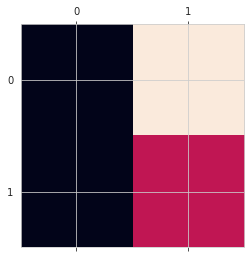

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
plt.matshow(confusion_matrix(y_test, pred_Y>0.4035797))
print(classification_report(y_test, pred_Y>0.4035797, target_names = ['No Consolidation', 'Consolidation']))

## **Edema**

0    4604
1    2303
Name: Edema, dtype: int64


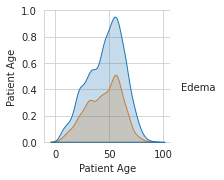

In [ ]:
positive_cases = np.sum(all_xray_df['Edema']==True)//2
oversample_factor = 4 # maximum number of cases in negative group so it isn't super rare
more_balanced_df = all_xray_df.groupby(['Edema']).apply(lambda x: x.sample(min(oversample_factor*positive_cases, x.shape[0]), 
                                                                                   replace = False)
                                                      ).reset_index(drop = True)

print(more_balanced_df['Edema'].value_counts())
sns.pairplot(more_balanced_df[['Patient Age', 'Edema']], hue='Edema')

In [ ]:
from sklearn.model_selection import train_test_split
raw_train_df, test_valid_df = train_test_split(more_balanced_df, 
                                   test_size = 0.30, 
                                   random_state = 2018,
                                   stratify = more_balanced_df[['Edema']])
valid_df, test_df = train_test_split(test_valid_df, 
                                   test_size = 0.40, 
                                   random_state = 2018,
                                   stratify = test_valid_df[['Edema']])
print('train', raw_train_df.shape[0], 'validation', valid_df.shape[0], 'test', test_df.shape[0])
print('train', raw_train_df['Edema'].value_counts())
print('test', test_df['Edema'].value_counts())
raw_train_df.sample(1)

train 4834 validation 1243 test 830
train 0    3222
1    1612
Name: Edema, dtype: int64
test 0    553
1    277
Name: Edema, dtype: int64


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],path,Pneumonia,Patient Male,Cardiomegaly,Emphysema,Effusion,Hernia,Nodule,Pneumothorax,Atelectasis,Pleural_Thickening,Mass,Edema,Consolidation,Infiltration,Fibrosis,Nothing
5765,00014058_002.png,Edema,12,14058,55,M,PA,1940,2021,0.194311,0.194311,/content/drive/MyDrive/Images/image7/00014058_...,False,1.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [ ]:
train_df = raw_train_df.groupby(['Edema']).apply(lambda x: x.sample(60000, replace = True)
                                                      ).reset_index(drop = True)
print('New Data Size:', train_df.shape[0], 'Old Size:', raw_train_df.shape[0])

New Data Size: 120000 Old Size: 4834


In [ ]:
from keras.preprocessing.image import ImageDataGenerator
idg = ImageDataGenerator(zoom_range=0.2,
                           fill_mode='nearest',
                           rotation_range=25,  
                           width_shift_range=0.25,  
                           height_shift_range=0.25,  
                           vertical_flip=False, 
                           horizontal_flip=True,
                           shear_range = 0.2,
                           samplewise_center=False, 
                           samplewise_std_normalization=False)


In [ ]:
SEED= 10
IMG_SIZE = (128, 128) 
####
def flow_from_dataframe(imgDatGen, df, batch_size, seed, img_size):
    #gc.collect()
    gen_img = imgDatGen.flow_from_dataframe(dataframe=more_balanced_df,
        x_col='path', y_col='Edema',
        batch_size=batch_size, seed=seed, shuffle=True, class_mode='other',
        target_size=img_size, color_mode='grayscale',
        drop_duplicates=False)

    
        
    while True:
        X1i = gen_img.next()
        #X2i = gen_img.next()
        #gc.collect()
        yield [X1i[0], X1i[1]]

In [ ]:
flow = flow_from_dataframe(idg, more_balanced_df, 7151, SEED, IMG_SIZE)

In [ ]:
t,y= next(flow)

--- Logging error ---
Traceback (most recent call last):
  File "/usr/lib/python3.7/logging/__init__.py", line 1025, in emit
    msg = self.format(record)
  File "/usr/lib/python3.7/logging/__init__.py", line 869, in format
    return fmt.format(record)
  File "/usr/lib/python3.7/logging/__init__.py", line 608, in format
    record.message = record.getMessage()
  File "/usr/lib/python3.7/logging/__init__.py", line 369, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "/usr/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.7/dist-packages/traitlets/config/application.py", line 846, in launch_instance
    app.start()
  File "/usr/local/lib/pytho

Found 6907 validated image filenames.


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(t,y, 
                                   test_size = 0.30, 
                                   random_state = 2018)


In [ ]:
from keras.applications.mobilenet import MobileNet
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from keras.models import Sequential
mobilenet_model = MobileNet(input_shape =  X_train.shape[1:], 
                                 include_top = False, weights = None)
mobilenet_GAP_model = Sequential()
mobilenet_GAP_model.add(mobilenet_model)
mobilenet_GAP_model.add(GlobalAveragePooling2D())
mobilenet_GAP_model.add(Dropout(0.5))
mobilenet_GAP_model.add(Dense(512))
mobilenet_GAP_model.add(Dropout(0.5))
mobilenet_GAP_model.add(Dense(1, activation = 'sigmoid'))
mobilenet_GAP_model.compile(optimizer = 'adam', loss = 'binary_crossentropy',
                           metrics = ['binary_accuracy', 'mae'])
mobilenet_GAP_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_128 (Functio  (None, 4, 4, 1024)       3228288   
 nal)                                                            
                                                                 
 global_average_pooling2d_3   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_6 (Dropout)         (None, 1024)              0         
                                                                 
 dense_6 (Dense)             (None, 512)               524800    
                                                                 
 dropout_7 (Dropout)         (None, 512)               0         
                                                                 
 dense_7 (Dense)             (None, 1)                

In [ ]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=3)
callbacks_list = [checkpoint, early]

In [ ]:
history_mobilenet_GAP = mobilenet_GAP_model.fit(X_train,y_train,
                                  steps_per_epoch=10,
                                  validation_data = (X_test, y_test), 
                                  epochs = 10, 
                                  callbacks = callbacks_list)

Epoch 1/10
10/10 [==============================] - ETA: 0s - loss: 1.5385 - binary_accuracy: 0.5972 - mae: 0.4088 
Epoch 00001: val_loss improved from inf to 0.68299, saving model to xray_class_weights.best.hdf5
10/10 [==============================] - 369s 36s/step - loss: 1.5385 - binary_accuracy: 0.5972 - mae: 0.4088 - val_loss: 0.6830 - val_binary_accuracy: 0.6686 - val_mae: 0.4947
Epoch 2/10
10/10 [==============================] - ETA: 0s - loss: 0.7483 - binary_accuracy: 0.6113 - mae: 0.4101 
Epoch 00002: val_loss did not improve from 0.68299
10/10 [==============================] - 366s 37s/step - loss: 0.7483 - binary_accuracy: 0.6113 - mae: 0.4101 - val_loss: 0.6872 - val_binary_accuracy: 0.6686 - val_mae: 0.4969
Epoch 3/10
10/10 [==============================] - ETA: 0s - loss: 0.6549 - binary_accuracy: 0.6572 - mae: 0.3903 
Epoch 00003: val_loss improved from 0.68299 to 0.67488, saving model to xray_class_weights.best.hdf5
10/10 [==============================] - 368s 37s

In [ ]:
pred_Y = mobilenet_GAP_model.predict(X_test, 
                          batch_size = 32, 
                          verbose = True)

65/65 [==============================] - 24s 357ms/step


In [ ]:
pred_Y

array([[0.43426156],
       [0.43426156],
       [0.43426156],
       ...,
       [0.43426156],
       [0.43426156],
       [0.43426156]], dtype=float32)

In [ ]:
min(pred_Y)

array([0.43426156], dtype=float32)

In [ ]:
print('test accuracy = ',mobilenet_GAP_model.evaluate(X_test,y_test, verbose=0)[1])

test accuracy =  0.6685962080955505


In [ ]:
from sklearn.metrics import roc_auc_score
print('roc score = ',roc_auc_score(y_test.astype(int), pred_Y))

roc score =  0.4975755685362672


              precision    recall  f1-score   support

    No Edema       0.67      0.97      0.79      1386
       Edema       0.29      0.02      0.04       687

    accuracy                           0.66      2073
   macro avg       0.48      0.50      0.42      2073
weighted avg       0.54      0.66      0.54      2073



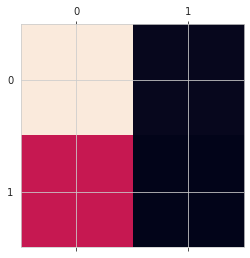

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
plt.matshow(confusion_matrix(y_test, pred_Y>0.43426156))
print(classification_report(y_test, pred_Y>0.43426156, target_names = ['No Edema', ' Edema']))

## **Effusion**

0    26632
1    13317
Name: Effusion, dtype: int64


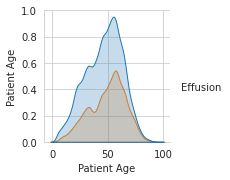

In [ ]:
positive_cases = np.sum(all_xray_df['Effusion']==True)//2
oversample_factor = 4 # maximum number of cases in negative group so it isn't super rare
more_balanced_df = all_xray_df.groupby(['Effusion']).apply(lambda x: x.sample(min(oversample_factor*positive_cases, x.shape[0]), 
                                                                                   replace = False)
                                                      ).reset_index(drop = True)

print(more_balanced_df['Effusion'].value_counts())
sns.pairplot(more_balanced_df[['Patient Age', 'Effusion']], hue='Effusion')

In [ ]:
from sklearn.model_selection import train_test_split
raw_train_df, test_valid_df = train_test_split(more_balanced_df, 
                                   test_size = 0.30, 
                                   random_state = 2018,
                                   stratify = more_balanced_df[['Effusion']])
valid_df, test_df = train_test_split(test_valid_df, 
                                   test_size = 0.40, 
                                   random_state = 2018,
                                   stratify = test_valid_df[['Effusion']])
print('train', raw_train_df.shape[0], 'validation', valid_df.shape[0], 'test', test_df.shape[0])
print('train', raw_train_df['Effusion'].value_counts())
print('test', test_df['Effusion'].value_counts())
raw_train_df.sample(1)

train 27964 validation 7191 test 4794
train 0    18642
1     9322
Name: Effusion, dtype: int64
test 0    3196
1    1598
Name: Effusion, dtype: int64


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],path,Pneumonia,Patient Male,Cardiomegaly,Emphysema,Effusion,Hernia,Nodule,Pneumothorax,Atelectasis,Pleural_Thickening,Mass,Edema,Consolidation,Infiltration,Fibrosis,Nothing
25481,00002704_010.png,No Finding,10,2704,38,F,AP,2500,2048,0.168,0.168,/content/drive/MyDrive/Images/image2/00002704_...,False,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [ ]:
train_df = raw_train_df.groupby(['Effusion']).apply(lambda x: x.sample(60000, replace = True)
                                                      ).reset_index(drop = True)
print('New Data Size:', train_df.shape[0], 'Old Size:', raw_train_df.shape[0])

New Data Size: 120000 Old Size: 27964


In [ ]:
from keras.preprocessing.image import ImageDataGenerator
idg = ImageDataGenerator(zoom_range=0.2,
                           fill_mode='nearest',
                           rotation_range=25,  
                           width_shift_range=0.25,  
                           height_shift_range=0.25,  
                           vertical_flip=False, 
                           horizontal_flip=True,
                           shear_range = 0.2,
                           samplewise_center=False, 
                           samplewise_std_normalization=False)


In [ ]:
SEED= 10
IMG_SIZE = (128, 128) 
####
def flow_from_dataframe(imgDatGen, df, batch_size, seed, img_size):
    #gc.collect()
    gen_img = imgDatGen.flow_from_dataframe(dataframe=more_balanced_df,
        x_col='path', y_col='Effusion',
        batch_size=batch_size, seed=seed, shuffle=True, class_mode='other',
        target_size=img_size, color_mode='grayscale',
        drop_duplicates=False)

    
        
    while True:
        X1i = gen_img.next()
        #X2i = gen_img.next()
        #gc.collect()
        yield [X1i[0], X1i[1]]

In [ ]:
flow = flow_from_dataframe(idg, more_balanced_df, 7151, SEED, IMG_SIZE)

In [ ]:
t,y= next(flow)

--- Logging error ---
Traceback (most recent call last):
  File "/usr/lib/python3.7/logging/__init__.py", line 1025, in emit
    msg = self.format(record)
  File "/usr/lib/python3.7/logging/__init__.py", line 869, in format
    return fmt.format(record)
  File "/usr/lib/python3.7/logging/__init__.py", line 608, in format
    record.message = record.getMessage()
  File "/usr/lib/python3.7/logging/__init__.py", line 369, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "/usr/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.7/dist-packages/traitlets/config/application.py", line 846, in launch_instance
    app.start()
  File "/usr/local/lib/pytho

Found 39949 validated image filenames.


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(t,y, 
                                   test_size = 0.30, 
                                   random_state = 2018)


In [ ]:
from keras.applications.mobilenet import MobileNet
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from keras.models import Sequential
mobilenet_model = MobileNet(input_shape =  X_train.shape[1:], 
                                 include_top = False, weights = None)
mobilenet_GAP_model = Sequential()
mobilenet_GAP_model.add(mobilenet_model)
mobilenet_GAP_model.add(GlobalAveragePooling2D())
mobilenet_GAP_model.add(Dropout(0.5))
mobilenet_GAP_model.add(Dense(512))
mobilenet_GAP_model.add(Dropout(0.5))
mobilenet_GAP_model.add(Dense(1, activation = 'sigmoid'))
mobilenet_GAP_model.compile(optimizer = 'adam', loss = 'binary_crossentropy',
                           metrics = ['binary_accuracy', 'mae'])
mobilenet_GAP_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_128 (Functio  (None, 4, 4, 1024)       3228288   
 nal)                                                            
                                                                 
 global_average_pooling2d_4   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_8 (Dropout)         (None, 1024)              0         
                                                                 
 dense_8 (Dense)             (None, 512)               524800    
                                                                 
 dropout_9 (Dropout)         (None, 512)               0         
                                                                 
 dense_9 (Dense)             (None, 1)                

In [ ]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=3)
callbacks_list = [checkpoint, early]

In [ ]:
history_mobilenet_GAP = mobilenet_GAP_model.fit(X_train,y_train,
                                  steps_per_epoch=10,
                                  validation_data = (X_test, y_test), 
                                  epochs = 10, 
                                  callbacks = callbacks_list)

Epoch 1/10
10/10 [==============================] - ETA: 0s - loss: 1.7476 - binary_accuracy: 0.5914 - mae: 0.4182 
Epoch 00001: val_loss improved from inf to 0.69250, saving model to xray_class_weights.best.hdf5
10/10 [==============================] - 384s 38s/step - loss: 1.7476 - binary_accuracy: 0.5914 - mae: 0.4182 - val_loss: 0.6925 - val_binary_accuracy: 0.6771 - val_mae: 0.4997
Epoch 2/10
10/10 [==============================] - ETA: 0s - loss: 0.9434 - binary_accuracy: 0.5876 - mae: 0.4347 
Epoch 00002: val_loss improved from 0.69250 to 0.69087, saving model to xray_class_weights.best.hdf5
10/10 [==============================] - 363s 37s/step - loss: 0.9434 - binary_accuracy: 0.5876 - mae: 0.4347 - val_loss: 0.6909 - val_binary_accuracy: 0.6771 - val_mae: 0.4988
Epoch 3/10
10/10 [==============================] - ETA: 0s - loss: 0.8035 - binary_accuracy: 0.6040 - mae: 0.4371 
Epoch 00003: val_loss improved from 0.69087 to 0.67639, saving model to xray_class_weights.best.hdf5

In [ ]:
pred_Y = mobilenet_GAP_model.predict(X_test, 
                          batch_size = 32, 
                          verbose = True)

68/68 [==============================] - 25s 353ms/step


In [ ]:
pred_Y

array([[0.45961887],
       [0.45961887],
       [0.45961887],
       ...,
       [0.45961887],
       [0.4596189 ],
       [0.45961887]], dtype=float32)

In [ ]:
min(pred_Y)

array([0.45961887], dtype=float32)

In [ ]:
print('test accuracy = ',mobilenet_GAP_model.evaluate(X_test,y_test, verbose=0)[1])

test accuracy =  0.67707359790802


In [ ]:
from sklearn.metrics import roc_auc_score
print('roc score = ',roc_auc_score(y_test.astype(int), pred_Y))

roc score =  0.5005323116128346


              precision    recall  f1-score   support

 No Effusion       0.68      0.98      0.80      1453
    Effusion       0.33      0.02      0.04       693

    accuracy                           0.67      2146
   macro avg       0.51      0.50      0.42      2146
weighted avg       0.57      0.67      0.56      2146



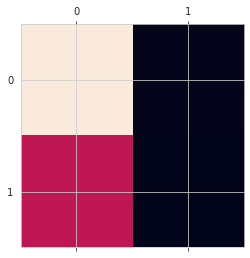

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
plt.matshow(confusion_matrix(y_test, pred_Y>0.45961887))
print(classification_report(y_test, pred_Y>0.45961887, target_names = ['No Effusion', ' Effusion']))

## **Emphysema**

0    5032
1    2516
Name: Emphysema, dtype: int64


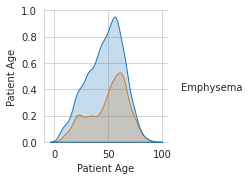

In [ ]:
positive_cases = np.sum(all_xray_df['Emphysema']==True)//2
oversample_factor = 4 # maximum number of cases in negative group so it isn't super rare
more_balanced_df = all_xray_df.groupby(['Emphysema']).apply(lambda x: x.sample(min(oversample_factor*positive_cases, x.shape[0]), 
                                                                                   replace = False)
                                                      ).reset_index(drop = True)

print(more_balanced_df['Emphysema'].value_counts())
sns.pairplot(more_balanced_df[['Patient Age', 'Emphysema']], hue='Emphysema')

In [ ]:
from sklearn.model_selection import train_test_split
raw_train_df, test_valid_df = train_test_split(more_balanced_df, 
                                   test_size = 0.30, 
                                   random_state = 2018,
                                   stratify = more_balanced_df[['Emphysema']])
valid_df, test_df = train_test_split(test_valid_df, 
                                   test_size = 0.40, 
                                   random_state = 2018,
                                   stratify = test_valid_df[['Emphysema']])
print('train', raw_train_df.shape[0], 'validation', valid_df.shape[0], 'test', test_df.shape[0])
print('train', raw_train_df['Emphysema'].value_counts())
print('test', test_df['Emphysema'].value_counts())
raw_train_df.sample(1)

train 5283 validation 1359 test 906
train 0    3522
1    1761
Name: Emphysema, dtype: int64
test 0    604
1    302
Name: Emphysema, dtype: int64


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],path,Pneumonia,Patient Male,Cardiomegaly,Emphysema,Effusion,Hernia,Nodule,Pneumothorax,Atelectasis,Pleural_Thickening,Mass,Edema,Consolidation,Infiltration,Fibrosis,Nothing
4623,00003723_000.png,No Finding,0,3723,59,F,PA,2048,2500,0.171,0.171,/content/drive/MyDrive/Images/image2/00003723_...,False,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [ ]:
train_df = raw_train_df.groupby(['Emphysema']).apply(lambda x: x.sample(60000, replace = True)
                                                      ).reset_index(drop = True)
print('New Data Size:', train_df.shape[0], 'Old Size:', raw_train_df.shape[0])

New Data Size: 120000 Old Size: 5283


In [ ]:
from keras.preprocessing.image import ImageDataGenerator
idg = ImageDataGenerator(zoom_range=0.2,
                           fill_mode='nearest',
                           rotation_range=25,  
                           width_shift_range=0.25,  
                           height_shift_range=0.25,  
                           vertical_flip=False, 
                           horizontal_flip=True,
                           shear_range = 0.2,
                           samplewise_center=False, 
                           samplewise_std_normalization=False)


In [ ]:
SEED= 10
IMG_SIZE = (128, 128) 
####
def flow_from_dataframe(imgDatGen, df, batch_size, seed, img_size):
    #gc.collect()
    gen_img = imgDatGen.flow_from_dataframe(dataframe=more_balanced_df,
        x_col='path', y_col='Emphysema',
        batch_size=batch_size, seed=seed, shuffle=True, class_mode='other',
        target_size=img_size, color_mode='grayscale',
        drop_duplicates=False)

    
        
    while True:
        X1i = gen_img.next()
        #X2i = gen_img.next()
        #gc.collect()
        yield [X1i[0], X1i[1]]

In [ ]:
flow = flow_from_dataframe(idg, more_balanced_df, 7151, SEED, IMG_SIZE)

In [ ]:
t,y= next(flow)

--- Logging error ---
Traceback (most recent call last):
  File "/usr/lib/python3.7/logging/__init__.py", line 1025, in emit
    msg = self.format(record)
  File "/usr/lib/python3.7/logging/__init__.py", line 869, in format
    return fmt.format(record)
  File "/usr/lib/python3.7/logging/__init__.py", line 608, in format
    record.message = record.getMessage()
  File "/usr/lib/python3.7/logging/__init__.py", line 369, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "/usr/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.7/dist-packages/traitlets/config/application.py", line 846, in launch_instance
    app.start()
  File "/usr/local/lib/pytho

Found 7548 validated image filenames.


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(t,y, 
                                   test_size = 0.30, 
                                   random_state = 2018)


In [ ]:
from keras.applications.mobilenet import MobileNet
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from keras.models import Sequential
mobilenet_model = MobileNet(input_shape =  X_train.shape[1:], 
                                 include_top = False, weights = None)
mobilenet_GAP_model = Sequential()
mobilenet_GAP_model.add(mobilenet_model)
mobilenet_GAP_model.add(GlobalAveragePooling2D())
mobilenet_GAP_model.add(Dropout(0.5))
mobilenet_GAP_model.add(Dense(512))
mobilenet_GAP_model.add(Dropout(0.5))
mobilenet_GAP_model.add(Dense(1, activation = 'sigmoid'))
mobilenet_GAP_model.compile(optimizer = 'adam', loss = 'binary_crossentropy',
                           metrics = ['binary_accuracy', 'mae'])
mobilenet_GAP_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_128 (Functio  (None, 4, 4, 1024)       3228288   
 nal)                                                            
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 512)               524800    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 5

In [ ]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=3)
callbacks_list = [checkpoint, early]

In [ ]:
history_mobilenet_GAP = mobilenet_GAP_model.fit(X_train,y_train,
                                  steps_per_epoch=10,
                                  validation_data = (X_test, y_test), 
                                  epochs = 10, 
                                  callbacks = callbacks_list)

Epoch 1/10
10/10 [==============================] - ETA: 0s - loss: 1.7851 - binary_accuracy: 0.5874 - mae: 0.4230 
Epoch 00001: val_loss improved from inf to 0.68665, saving model to xray_class_weights.best.hdf5
10/10 [==============================] - 364s 36s/step - loss: 1.7851 - binary_accuracy: 0.5874 - mae: 0.4230 - val_loss: 0.6866 - val_binary_accuracy: 0.6612 - val_mae: 0.4966
Epoch 2/10
10/10 [==============================] - ETA: 0s - loss: 0.8414 - binary_accuracy: 0.5874 - mae: 0.4391 
Epoch 00002: val_loss improved from 0.68665 to 0.67762, saving model to xray_class_weights.best.hdf5
10/10 [==============================] - 360s 36s/step - loss: 0.8414 - binary_accuracy: 0.5874 - mae: 0.4391 - val_loss: 0.6776 - val_binary_accuracy: 0.6612 - val_mae: 0.4916
Epoch 3/10
10/10 [==============================] - ETA: 0s - loss: 0.7867 - binary_accuracy: 0.6066 - mae: 0.4449 
Epoch 00003: val_loss improved from 0.67762 to 0.65922, saving model to xray_class_weights.best.hdf5

In [ ]:
pred_Y = mobilenet_GAP_model.predict(X_test, 
                          batch_size = 32, 
                          verbose = True)

68/68 [==============================] - 24s 340ms/step


In [ ]:
pred_Y

array([[0.36108774],
       [0.36108774],
       [0.36108774],
       ...,
       [0.36108774],
       [0.36108774],
       [0.36108774]], dtype=float32)

In [ ]:
min(pred_Y)

array([0.36108774], dtype=float32)

In [ ]:
print('test accuracy = ',mobilenet_GAP_model.evaluate(X_test,y_test, verbose=0)[1])

test accuracy =  0.661230206489563


In [ ]:
from sklearn.metrics import roc_auc_score
print('roc score = ',roc_auc_score(y_test.astype(int), pred_Y))

roc score =  0.5032182611114826


              precision    recall  f1-score   support

No Emphysema       0.66      0.98      0.79      1419
   Emphysema       0.41      0.02      0.05       727

    accuracy                           0.66      2146
   macro avg       0.54      0.50      0.42      2146
weighted avg       0.58      0.66      0.54      2146



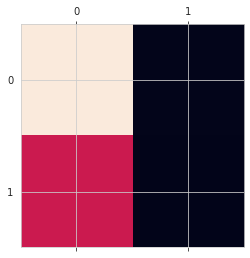

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
plt.matshow(confusion_matrix(y_test, pred_Y>0.36108774))
print(classification_report(y_test, pred_Y>0.36108774, target_names = ['No Emphysema', 'Emphysema']))

## **Fibrosis**

0    3372
1    1686
Name: Fibrosis, dtype: int64


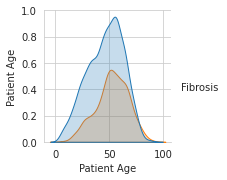

In [ ]:
positive_cases = np.sum(all_xray_df['Fibrosis']==True)//2
oversample_factor = 4 # maximum number of cases in negative group so it isn't super rare
more_balanced_df = all_xray_df.groupby(['Fibrosis']).apply(lambda x: x.sample(min(oversample_factor*positive_cases, x.shape[0]), 
                                                                                   replace = False)
                                                      ).reset_index(drop = True)

print(more_balanced_df['Fibrosis'].value_counts())
sns.pairplot(more_balanced_df[['Patient Age', 'Fibrosis']], hue='Fibrosis')

In [ ]:
from sklearn.model_selection import train_test_split
raw_train_df, test_valid_df = train_test_split(more_balanced_df, 
                                   test_size = 0.30, 
                                   random_state = 2018,
                                   stratify = more_balanced_df[['Fibrosis']])
valid_df, test_df = train_test_split(test_valid_df, 
                                   test_size = 0.40, 
                                   random_state = 2018,
                                   stratify = test_valid_df[['Fibrosis']])
print('train', raw_train_df.shape[0], 'validation', valid_df.shape[0], 'test', test_df.shape[0])
print('train', raw_train_df['Fibrosis'].value_counts())
print('test', test_df['Fibrosis'].value_counts())
raw_train_df.sample(1)

train 3540 validation 910 test 608
train 0    2360
1    1180
Name: Fibrosis, dtype: int64
test 0    405
1    203
Name: Fibrosis, dtype: int64


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],path,Pneumonia,Patient Male,Cardiomegaly,Emphysema,Effusion,Hernia,Nodule,Pneumothorax,Atelectasis,Pleural_Thickening,Mass,Edema,Consolidation,Infiltration,Fibrosis,Nothing
155,00011235_007.png,No Finding,7,11235,68,M,PA,2992,2991,0.143,0.143,/content/drive/MyDrive/Images/image5/00011235_...,False,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [ ]:
train_df = raw_train_df.groupby(['Fibrosis']).apply(lambda x: x.sample(60000, replace = True)
                                                      ).reset_index(drop = True)
print('New Data Size:', train_df.shape[0], 'Old Size:', raw_train_df.shape[0])

New Data Size: 120000 Old Size: 3540


In [ ]:
from keras.preprocessing.image import ImageDataGenerator
idg = ImageDataGenerator(zoom_range=0.2,
                           fill_mode='nearest',
                           rotation_range=25,  
                           width_shift_range=0.25,  
                           height_shift_range=0.25,  
                           vertical_flip=False, 
                           horizontal_flip=True,
                           shear_range = 0.2,
                           samplewise_center=False, 
                           samplewise_std_normalization=False)


In [ ]:
SEED= 10
IMG_SIZE = (128, 128) 
####
def flow_from_dataframe(imgDatGen, df, batch_size, seed, img_size):
    #gc.collect()
    gen_img = imgDatGen.flow_from_dataframe(dataframe=more_balanced_df,
        x_col='path', y_col='Fibrosis',
        batch_size=batch_size, seed=seed, shuffle=True, class_mode='other',
        target_size=img_size, color_mode='grayscale',
        drop_duplicates=False)

    
        
    while True:
        X1i = gen_img.next()
        #X2i = gen_img.next()
        #gc.collect()
        yield [X1i[0], X1i[1]]

In [ ]:
flow = flow_from_dataframe(idg, more_balanced_df, 7151, SEED, IMG_SIZE)

In [ ]:
t,y= next(flow)

--- Logging error ---
Traceback (most recent call last):
  File "/usr/lib/python3.7/logging/__init__.py", line 1025, in emit
    msg = self.format(record)
  File "/usr/lib/python3.7/logging/__init__.py", line 869, in format
    return fmt.format(record)
  File "/usr/lib/python3.7/logging/__init__.py", line 608, in format
    record.message = record.getMessage()
  File "/usr/lib/python3.7/logging/__init__.py", line 369, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "/usr/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.7/dist-packages/traitlets/config/application.py", line 846, in launch_instance
    app.start()
  File "/usr/local/lib/pytho

Found 5058 validated image filenames.


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(t,y, 
                                   test_size = 0.30, 
                                   random_state = 2018)


In [ ]:
from keras.applications.mobilenet import MobileNet
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from keras.models import Sequential
mobilenet_model = MobileNet(input_shape =  X_train.shape[1:], 
                                 include_top = False, weights = None)
mobilenet_GAP_model = Sequential()
mobilenet_GAP_model.add(mobilenet_model)
mobilenet_GAP_model.add(GlobalAveragePooling2D())
mobilenet_GAP_model.add(Dropout(0.5))
mobilenet_GAP_model.add(Dense(512))
mobilenet_GAP_model.add(Dropout(0.5))
mobilenet_GAP_model.add(Dense(1, activation = 'sigmoid'))
mobilenet_GAP_model.compile(optimizer = 'adam', loss = 'binary_crossentropy',
                           metrics = ['binary_accuracy', 'mae'])
mobilenet_GAP_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_128 (Functio  (None, 4, 4, 1024)       3228288   
 nal)                                                            
                                                                 
 global_average_pooling2d_1   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_2 (Dropout)         (None, 1024)              0         
                                                                 
 dense_2 (Dense)             (None, 512)               524800    
                                                                 
 dropout_3 (Dropout)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                

In [ ]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=3)
callbacks_list = [checkpoint, early]

In [ ]:
history_mobilenet_GAP = mobilenet_GAP_model.fit(X_train,y_train,
                                  steps_per_epoch=10,
                                  validation_data = (X_test, y_test), 
                                  epochs = 10, 
                                  callbacks = callbacks_list)

Epoch 1/10
10/10 [==============================] - ETA: 0s - loss: 1.2674 - binary_accuracy: 0.5653 - mae: 0.4450 
Epoch 00001: val_loss improved from inf to 0.68042, saving model to xray_class_weights.best.hdf5
10/10 [==============================] - 248s 25s/step - loss: 1.2674 - binary_accuracy: 0.5653 - mae: 0.4450 - val_loss: 0.6804 - val_binary_accuracy: 0.6647 - val_mae: 0.4932
Epoch 2/10
10/10 [==============================] - ETA: 0s - loss: 0.9223 - binary_accuracy: 0.5946 - mae: 0.4290 
Epoch 00002: val_loss improved from 0.68042 to 0.66302, saving model to xray_class_weights.best.hdf5
10/10 [==============================] - 240s 24s/step - loss: 0.9223 - binary_accuracy: 0.5946 - mae: 0.4290 - val_loss: 0.6630 - val_binary_accuracy: 0.6647 - val_mae: 0.4820
Epoch 3/10
10/10 [==============================] - ETA: 0s - loss: 0.8693 - binary_accuracy: 0.6257 - mae: 0.4186 
Epoch 00003: val_loss improved from 0.66302 to 0.65650, saving model to xray_class_weights.best.hdf5

In [ ]:
pred_Y = mobilenet_GAP_model.predict(X_test, 
                          batch_size = 32, 
                          verbose = True)

48/48 [==============================] - 17s 334ms/step


In [ ]:
pred_Y

array([[0.2990173 ],
       [0.2990173 ],
       [0.2990173 ],
       ...,
       [0.2990173 ],
       [0.29901737],
       [0.29901737]], dtype=float32)

In [ ]:
min(pred_Y)

array([0.29901728], dtype=float32)

In [ ]:
print('test accuracy = ',mobilenet_GAP_model.evaluate(X_test,y_test, verbose=0)[1])

test accuracy =  0.664690375328064


In [ ]:
from sklearn.metrics import roc_auc_score
print('roc score = ',roc_auc_score(y_test.astype(int), pred_Y))

roc score =  0.5135158816233466


              precision    recall  f1-score   support

 No Fibrosis       0.76      0.05      0.09      1009
    Fibrosis       0.34      0.97      0.50       509

    accuracy                           0.36      1518
   macro avg       0.55      0.51      0.30      1518
weighted avg       0.62      0.36      0.23      1518



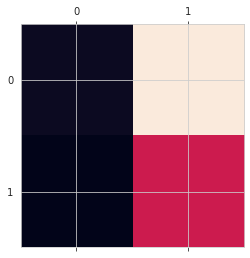

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
plt.matshow(confusion_matrix(y_test, pred_Y>0.29901728))
print(classification_report(y_test, pred_Y>0.29901728, target_names = ['No Fibrosis', 'Fibrosis']))

## **Hernia**

0    452
1    227
Name: Hernia, dtype: int64


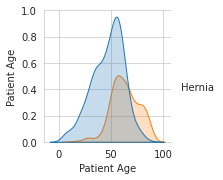

In [ ]:
positive_cases = np.sum(all_xray_df['Hernia']==True)//2
oversample_factor = 4 # maximum number of cases in negative group so it isn't super rare
more_balanced_df = all_xray_df.groupby(['Hernia']).apply(lambda x: x.sample(min(oversample_factor*positive_cases, x.shape[0]), 
                                                                                   replace = False)
                                                      ).reset_index(drop = True)

print(more_balanced_df['Hernia'].value_counts())
sns.pairplot(more_balanced_df[['Patient Age', 'Hernia']], hue='Hernia')

In [ ]:
from sklearn.model_selection import train_test_split
raw_train_df, test_valid_df = train_test_split(more_balanced_df, 
                                   test_size = 0.30, 
                                   random_state = 2018,
                                   stratify = more_balanced_df[['Hernia']])
valid_df, test_df = train_test_split(test_valid_df, 
                                   test_size = 0.40, 
                                   random_state = 2018,
                                   stratify = test_valid_df[['Hernia']])
print('train', raw_train_df.shape[0], 'validation', valid_df.shape[0], 'test', test_df.shape[0])
print('train', raw_train_df['Hernia'].value_counts())
print('test', test_df['Hernia'].value_counts())
raw_train_df.sample(1)

train 475 validation 122 test 82
train 0    316
1    159
Name: Hernia, dtype: int64
test 0    55
1    27
Name: Hernia, dtype: int64


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],path,Pneumonia,Patient Male,Cardiomegaly,Emphysema,Effusion,Hernia,Nodule,Pneumothorax,Atelectasis,Pleural_Thickening,Mass,Edema,Consolidation,Infiltration,Fibrosis,Nothing
175,00021552_016.png,Atelectasis|Infiltration|Mass|Pleural_Thickening,3,21552,50,M,PA,2992,2991,0.143,0.143,/content/drive/MyDrive/Images/image10/00021552...,False,1.0,0,0,0,0,0,0,1,1,1,0,0,1,0,0


In [ ]:
train_df = raw_train_df.groupby(['Hernia']).apply(lambda x: x.sample(60000, replace = True)
                                                      ).reset_index(drop = True)
print('New Data Size:', train_df.shape[0], 'Old Size:', raw_train_df.shape[0])

New Data Size: 120000 Old Size: 475


In [ ]:
from keras.preprocessing.image import ImageDataGenerator
idg = ImageDataGenerator(zoom_range=0.2,
                           fill_mode='nearest',
                           rotation_range=25,  
                           width_shift_range=0.25,  
                           height_shift_range=0.25,  
                           vertical_flip=False, 
                           horizontal_flip=True,
                           shear_range = 0.2,
                           samplewise_center=False, 
                           samplewise_std_normalization=False)


In [ ]:
SEED= 10
IMG_SIZE = (128, 128) 
####
def flow_from_dataframe(imgDatGen, df, batch_size, seed, img_size):
    #gc.collect()
    gen_img = imgDatGen.flow_from_dataframe(dataframe=more_balanced_df,
        x_col='path', y_col='Hernia',
        batch_size=batch_size, seed=seed, shuffle=True, class_mode='other',
        target_size=img_size, color_mode='grayscale',
        drop_duplicates=False)

    
        
    while True:
        X1i = gen_img.next()
        #X2i = gen_img.next()
        #gc.collect()
        yield [X1i[0], X1i[1]]

In [ ]:
flow = flow_from_dataframe(idg, more_balanced_df, 7151, SEED, IMG_SIZE)

In [ ]:
t,y= next(flow)

--- Logging error ---
Traceback (most recent call last):
  File "/usr/lib/python3.7/logging/__init__.py", line 1025, in emit
    msg = self.format(record)
  File "/usr/lib/python3.7/logging/__init__.py", line 869, in format
    return fmt.format(record)
  File "/usr/lib/python3.7/logging/__init__.py", line 608, in format
    record.message = record.getMessage()
  File "/usr/lib/python3.7/logging/__init__.py", line 369, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "/usr/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.7/dist-packages/traitlets/config/application.py", line 846, in launch_instance
    app.start()
  File "/usr/local/lib/pytho

Found 679 validated image filenames.


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(t,y, 
                                   test_size = 0.30, 
                                   random_state = 2018)


In [ ]:
from keras.applications.mobilenet import MobileNet
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from keras.models import Sequential
mobilenet_model = MobileNet(input_shape =  X_train.shape[1:], 
                                 include_top = False, weights = None)
mobilenet_GAP_model = Sequential()
mobilenet_GAP_model.add(mobilenet_model)
mobilenet_GAP_model.add(GlobalAveragePooling2D())
mobilenet_GAP_model.add(Dropout(0.5))
mobilenet_GAP_model.add(Dense(512))
mobilenet_GAP_model.add(Dropout(0.5))
mobilenet_GAP_model.add(Dense(1, activation = 'sigmoid'))
mobilenet_GAP_model.compile(optimizer = 'adam', loss = 'binary_crossentropy',
                           metrics = ['binary_accuracy', 'mae'])
mobilenet_GAP_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_128 (Functio  (None, 4, 4, 1024)       3228288   
 nal)                                                            
                                                                 
 global_average_pooling2d_2   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_4 (Dropout)         (None, 1024)              0         
                                                                 
 dense_4 (Dense)             (None, 512)               524800    
                                                                 
 dropout_5 (Dropout)         (None, 512)               0         
                                                                 
 dense_5 (Dense)             (None, 1)                

In [ ]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=3)
callbacks_list = [checkpoint, early]

In [ ]:
history_mobilenet_GAP = mobilenet_GAP_model.fit(X_train,y_train,
                                  steps_per_epoch=10,
                                  validation_data = (X_test, y_test), 
                                  epochs = 10, 
                                  callbacks = callbacks_list)

Epoch 1/10
10/10 [==============================] - ETA: 0s - loss: 1.4305 - binary_accuracy: 0.5789 - mae: 0.4107
Epoch 00001: val_loss improved from inf to 0.68628, saving model to xray_class_weights.best.hdf5
10/10 [==============================] - 35s 3s/step - loss: 1.4305 - binary_accuracy: 0.5789 - mae: 0.4107 - val_loss: 0.6863 - val_binary_accuracy: 0.6225 - val_mae: 0.4963
Epoch 2/10
10/10 [==============================] - ETA: 0s - loss: 0.8081 - binary_accuracy: 0.6358 - mae: 0.3806
Epoch 00002: val_loss did not improve from 0.68628
10/10 [==============================] - 33s 3s/step - loss: 0.8081 - binary_accuracy: 0.6358 - mae: 0.3806 - val_loss: 0.6901 - val_binary_accuracy: 0.6225 - val_mae: 0.4985
Epoch 3/10
10/10 [==============================] - ETA: 0s - loss: 0.7185 - binary_accuracy: 0.6842 - mae: 0.3716
Epoch 00003: val_loss improved from 0.68628 to 0.67875, saving model to xray_class_weights.best.hdf5
10/10 [==============================] - 35s 4s/step - l

In [ ]:
pred_Y = mobilenet_GAP_model.predict(X_test, 
                          batch_size = 32, 
                          verbose = True)

In [ ]:
pred_Y

array([[0.23362523],
       [0.23362523],
       [0.23362523],
       [0.23362523],
       [0.23362523],
       [0.23362523],
       [0.23362523],
       [0.23362523],
       [0.23362523],
       [0.23362523],
       [0.23362523],
       [0.23362523],
       [0.23362523],
       [0.23362523],
       [0.23362523],
       [0.23362523],
       [0.23362523],
       [0.23362523],
       [0.23362523],
       [0.23362523],
       [0.23362523],
       [0.23362523],
       [0.23362523],
       [0.23362523],
       [0.23362523],
       [0.23362523],
       [0.23362523],
       [0.23362523],
       [0.23362523],
       [0.23362523],
       [0.23362523],
       [0.23362523],
       [0.23362523],
       [0.23362523],
       [0.23362523],
       [0.23362523],
       [0.23362523],
       [0.23362523],
       [0.23362523],
       [0.23362523],
       [0.23362523],
       [0.23362523],
       [0.23362523],
       [0.23362523],
       [0.23362523],
       [0.23362523],
       [0.23362523],
       [0.233

In [ ]:
min(pred_Y)

array([0.23362523], dtype=float32)

In [ ]:
print('test accuracy = ',mobilenet_GAP_model.evaluate(X_test,y_test, verbose=0)[1])

In [ ]:
from sklearn.metrics import roc_auc_score
print('roc score = ',roc_auc_score(y_test.astype(int), pred_Y))

roc score =  0.5
roc score =  0.5


              precision    recall  f1-score   support

   No Hernia       0.62      1.00      0.77       127
      Hernia       0.00      0.00      0.00        77

    accuracy                           0.62       204
   macro avg       0.31      0.50      0.38       204
weighted avg       0.39      0.62      0.48       204



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


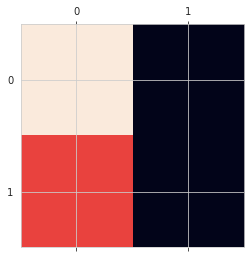

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
plt.matshow(confusion_matrix(y_test, pred_Y>0.23362523))
print(classification_report(y_test, pred_Y>0.23362523, target_names = ['No Hernia', 'Hernia']))

## **Infiltration**

0    39788
1    19894
Name: Infiltration, dtype: int64


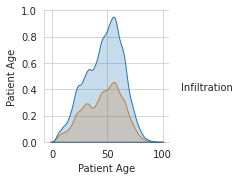

In [ ]:
positive_cases = np.sum(all_xray_df['Infiltration']==True)//2
oversample_factor = 4 # maximum number of cases in negative group so it isn't super rare
more_balanced_df = all_xray_df.groupby(['Infiltration']).apply(lambda x: x.sample(min(oversample_factor*positive_cases, x.shape[0]), 
                                                                                   replace = False)
                                                      ).reset_index(drop = True)

print(more_balanced_df['Infiltration'].value_counts())
sns.pairplot(more_balanced_df[['Patient Age', 'Infiltration']], hue='Infiltration')

In [ ]:
from sklearn.model_selection import train_test_split
raw_train_df, test_valid_df = train_test_split(more_balanced_df, 
                                   test_size = 0.30, 
                                   random_state = 2018,
                                   stratify = more_balanced_df[['Infiltration']])
valid_df, test_df = train_test_split(test_valid_df, 
                                   test_size = 0.40, 
                                   random_state = 2018,
                                   stratify = test_valid_df[['Infiltration']])
print('train', raw_train_df.shape[0], 'validation', valid_df.shape[0], 'test', test_df.shape[0])
print('train', raw_train_df['Infiltration'].value_counts())
print('test', test_df['Infiltration'].value_counts())
raw_train_df.sample(1)

train 41777 validation 10743 test 7162
train 0    27851
1    13926
Name: Infiltration, dtype: int64
test 0    4775
1    2387
Name: Infiltration, dtype: int64


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],path,Pneumonia,Patient Male,Cardiomegaly,Emphysema,Effusion,Hernia,Nodule,Pneumothorax,Atelectasis,Pleural_Thickening,Mass,Edema,Consolidation,Infiltration,Fibrosis,Nothing
34171,00005520_000.png,No Finding,0,5520,42,M,PA,2048,2500,0.168,0.168,/content/drive/MyDrive/Images/image3/00005520_...,False,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [ ]:
train_df = raw_train_df.groupby(['Infiltration']).apply(lambda x: x.sample(60000, replace = True)
                                                      ).reset_index(drop = True)
print('New Data Size:', train_df.shape[0], 'Old Size:', raw_train_df.shape[0])

New Data Size: 120000 Old Size: 41777


In [ ]:
from keras.preprocessing.image import ImageDataGenerator
idg = ImageDataGenerator(zoom_range=0.2,
                           fill_mode='nearest',
                           rotation_range=25,  
                           width_shift_range=0.25,  
                           height_shift_range=0.25,  
                           vertical_flip=False, 
                           horizontal_flip=True,
                           shear_range = 0.2,
                           samplewise_center=False, 
                           samplewise_std_normalization=False)


In [ ]:
SEED= 10
IMG_SIZE = (128, 128) 
####
def flow_from_dataframe(imgDatGen, df, batch_size, seed, img_size):
    #gc.collect()
    gen_img = imgDatGen.flow_from_dataframe(dataframe=more_balanced_df,
        x_col='path', y_col='Infiltration',
        batch_size=batch_size, seed=seed, shuffle=True, class_mode='other',
        target_size=img_size, color_mode='grayscale',
        drop_duplicates=False)

    
        
    while True:
        X1i = gen_img.next()
        #X2i = gen_img.next()
        #gc.collect()
        yield [X1i[0], X1i[1]]

In [ ]:
flow = flow_from_dataframe(idg, more_balanced_df, 7151, SEED, IMG_SIZE)

In [ ]:
t,y= next(flow)

--- Logging error ---
Traceback (most recent call last):
  File "/usr/lib/python3.7/logging/__init__.py", line 1025, in emit
    msg = self.format(record)
  File "/usr/lib/python3.7/logging/__init__.py", line 869, in format
    return fmt.format(record)
  File "/usr/lib/python3.7/logging/__init__.py", line 608, in format
    record.message = record.getMessage()
  File "/usr/lib/python3.7/logging/__init__.py", line 369, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "/usr/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.7/dist-packages/traitlets/config/application.py", line 846, in launch_instance
    app.start()
  File "/usr/local/lib/pytho

Found 59682 validated image filenames.


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(t,y, 
                                   test_size = 0.30, 
                                   random_state = 2018)


In [ ]:
from keras.applications.mobilenet import MobileNet
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from keras.models import Sequential
mobilenet_model = MobileNet(input_shape =  X_train.shape[1:], 
                                 include_top = False, weights = None)
mobilenet_GAP_model = Sequential()
mobilenet_GAP_model.add(mobilenet_model)
mobilenet_GAP_model.add(GlobalAveragePooling2D())
mobilenet_GAP_model.add(Dropout(0.5))
mobilenet_GAP_model.add(Dense(512))
mobilenet_GAP_model.add(Dropout(0.5))
mobilenet_GAP_model.add(Dense(1, activation = 'sigmoid'))
mobilenet_GAP_model.compile(optimizer = 'adam', loss = 'binary_crossentropy',
                           metrics = ['binary_accuracy', 'mae'])
mobilenet_GAP_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_128 (Functio  (None, 4, 4, 1024)       3228288   
 nal)                                                            
                                                                 
 global_average_pooling2d_3   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_6 (Dropout)         (None, 1024)              0         
                                                                 
 dense_6 (Dense)             (None, 512)               524800    
                                                                 
 dropout_7 (Dropout)         (None, 512)               0         
                                                                 
 dense_7 (Dense)             (None, 1)                

In [ ]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=3)
callbacks_list = [checkpoint, early]

In [ ]:
history_mobilenet_GAP = mobilenet_GAP_model.fit(X_train,y_train,
                                  steps_per_epoch=10,
                                  validation_data = (X_test, y_test), 
                                  epochs = 10, 
                                  callbacks = callbacks_list)

Epoch 1/10
10/10 [==============================] - ETA: 0s - loss: 2.4505 - binary_accuracy: 0.5810 - mae: 0.4242 
Epoch 00001: val_loss improved from inf to 0.70556, saving model to xray_class_weights.best.hdf5
10/10 [==============================] - 360s 36s/step - loss: 2.4505 - binary_accuracy: 0.5810 - mae: 0.4242 - val_loss: 0.7056 - val_binary_accuracy: 0.3341 - val_mae: 0.5059
Epoch 2/10
10/10 [==============================] - ETA: 0s - loss: 1.2420 - binary_accuracy: 0.5493 - mae: 0.4650 
Epoch 00002: val_loss improved from 0.70556 to 0.69203, saving model to xray_class_weights.best.hdf5
10/10 [==============================] - 348s 35s/step - loss: 1.2420 - binary_accuracy: 0.5493 - mae: 0.4650 - val_loss: 0.6920 - val_binary_accuracy: 0.6659 - val_mae: 0.4994
Epoch 3/10
10/10 [==============================] - ETA: 0s - loss: 0.8382 - binary_accuracy: 0.5606 - mae: 0.4633 
Epoch 00003: val_loss improved from 0.69203 to 0.65767, saving model to xray_class_weights.best.hdf5

In [ ]:
pred_Y = mobilenet_GAP_model.predict(X_test, 
                          batch_size = 32, 
                          verbose = True)

68/68 [==============================] - 22s 320ms/step


In [ ]:
pred_Y

array([[0.4691919],
       [0.4691919],
       [0.4691919],
       ...,
       [0.4691919],
       [0.4691919],
       [0.4691919]], dtype=float32)

In [ ]:
min(pred_Y)

array([0.46919188], dtype=float32)

In [ ]:
print('test accuracy = ',mobilenet_GAP_model.evaluate(X_test,y_test, verbose=0)[1])

test accuracy =  0.6658900380134583


In [ ]:
from sklearn.metrics import roc_auc_score
print('roc score = ',roc_auc_score(y_test.astype(int), pred_Y))

roc score =  0.4986223798132527


                 precision    recall  f1-score   support

No Infiltration       0.61      0.01      0.02      1429
   Infiltration       0.33      0.99      0.50       717

       accuracy                           0.34      2146
      macro avg       0.47      0.50      0.26      2146
   weighted avg       0.52      0.34      0.18      2146



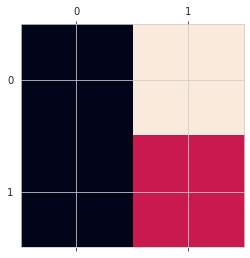

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
plt.matshow(confusion_matrix(y_test, pred_Y>0.46919188))
print(classification_report(y_test, pred_Y>0.46919188, target_names = ['No Infiltration', 'Infiltration']))

## **Mass**

0    11564
1     5782
Name: Mass, dtype: int64


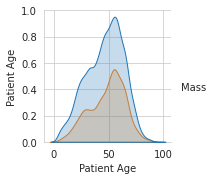

In [ ]:
positive_cases = np.sum(all_xray_df['Mass']==True)//2
oversample_factor = 4 # maximum number of cases in negative group so it isn't super rare
more_balanced_df = all_xray_df.groupby(['Mass']).apply(lambda x: x.sample(min(oversample_factor*positive_cases, x.shape[0]), 
                                                                                   replace = False)
                                                      ).reset_index(drop = True)

print(more_balanced_df['Mass'].value_counts())
sns.pairplot(more_balanced_df[['Patient Age', 'Mass']], hue='Mass')

In [ ]:
from sklearn.model_selection import train_test_split
raw_train_df, test_valid_df = train_test_split(more_balanced_df, 
                                   test_size = 0.30, 
                                   random_state = 2018,
                                   stratify = more_balanced_df[['Mass']])
valid_df, test_df = train_test_split(test_valid_df, 
                                   test_size = 0.40, 
                                   random_state = 2018,
                                   stratify = test_valid_df[['Mass']])
print('train', raw_train_df.shape[0], 'validation', valid_df.shape[0], 'test', test_df.shape[0])
print('train', raw_train_df['Mass'].value_counts())
print('test', test_df['Mass'].value_counts())
raw_train_df.sample(1)

train 12142 validation 3122 test 2082
train 0    8095
1    4047
Name: Mass, dtype: int64
test 0    1388
1     694
Name: Mass, dtype: int64


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],path,Pneumonia,Patient Male,Cardiomegaly,Emphysema,Effusion,Hernia,Nodule,Pneumothorax,Atelectasis,Pleural_Thickening,Mass,Edema,Consolidation,Infiltration,Fibrosis,Nothing
4356,00000768_000.png,No Finding,0,768,54,M,PA,2596,2901,0.143,0.143,/content/drive/MyDrive/Images/image1/00000768_...,False,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [ ]:
train_df = raw_train_df.groupby(['Mass']).apply(lambda x: x.sample(60000, replace = True)
                                                      ).reset_index(drop = True)
print('New Data Size:', train_df.shape[0], 'Old Size:', raw_train_df.shape[0])

New Data Size: 120000 Old Size: 12142


In [ ]:
from keras.preprocessing.image import ImageDataGenerator
idg = ImageDataGenerator(zoom_range=0.2,
                           fill_mode='nearest',
                           rotation_range=25,  
                           width_shift_range=0.25,  
                           height_shift_range=0.25,  
                           vertical_flip=False, 
                           horizontal_flip=True,
                           shear_range = 0.2,
                           samplewise_center=False, 
                           samplewise_std_normalization=False)


In [ ]:
SEED= 10
IMG_SIZE = (128, 128) 
####
def flow_from_dataframe(imgDatGen, df, batch_size, seed, img_size):
    #gc.collect()
    gen_img = imgDatGen.flow_from_dataframe(dataframe=more_balanced_df,
        x_col='path', y_col='Mass',
        batch_size=batch_size, seed=seed, shuffle=True, class_mode='other',
        target_size=img_size, color_mode='grayscale',
        drop_duplicates=False)

    
        
    while True:
        X1i = gen_img.next()
        #X2i = gen_img.next()
        #gc.collect()
        yield [X1i[0], X1i[1]]

In [ ]:
flow = flow_from_dataframe(idg, more_balanced_df, 7151, SEED, IMG_SIZE)

In [ ]:
t,y= next(flow)

--- Logging error ---
Traceback (most recent call last):
  File "/usr/lib/python3.7/logging/__init__.py", line 1025, in emit
    msg = self.format(record)
  File "/usr/lib/python3.7/logging/__init__.py", line 869, in format
    return fmt.format(record)
  File "/usr/lib/python3.7/logging/__init__.py", line 608, in format
    record.message = record.getMessage()
  File "/usr/lib/python3.7/logging/__init__.py", line 369, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "/usr/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.7/dist-packages/traitlets/config/application.py", line 846, in launch_instance
    app.start()
  File "/usr/local/lib/pytho

Found 17346 validated image filenames.


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(t,y, 
                                   test_size = 0.30, 
                                   random_state = 2018)


In [ ]:
from keras.applications.mobilenet import MobileNet
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from keras.models import Sequential
mobilenet_model = MobileNet(input_shape =  X_train.shape[1:], 
                                 include_top = False, weights = None)
mobilenet_GAP_model = Sequential()
mobilenet_GAP_model.add(mobilenet_model)
mobilenet_GAP_model.add(GlobalAveragePooling2D())
mobilenet_GAP_model.add(Dropout(0.5))
mobilenet_GAP_model.add(Dense(512))
mobilenet_GAP_model.add(Dropout(0.5))
mobilenet_GAP_model.add(Dense(1, activation = 'sigmoid'))
mobilenet_GAP_model.compile(optimizer = 'adam', loss = 'binary_crossentropy',
                           metrics = ['binary_accuracy', 'mae'])
mobilenet_GAP_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_128 (Functio  (None, 4, 4, 1024)       3228288   
 nal)                                                            
                                                                 
 global_average_pooling2d_4   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_8 (Dropout)         (None, 1024)              0         
                                                                 
 dense_8 (Dense)             (None, 512)               524800    
                                                                 
 dropout_9 (Dropout)         (None, 512)               0         
                                                                 
 dense_9 (Dense)             (None, 1)                

In [ ]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=3)
callbacks_list = [checkpoint, early]

In [ ]:
history_mobilenet_GAP = mobilenet_GAP_model.fit(X_train,y_train,
                                  steps_per_epoch=10,
                                  validation_data = (X_test, y_test), 
                                  epochs = 10, 
                                  callbacks = callbacks_list)

Epoch 1/10
10/10 [==============================] - ETA: 0s - loss: 1.7789 - binary_accuracy: 0.5692 - mae: 0.4307 
Epoch 00001: val_loss improved from inf to 0.68247, saving model to xray_class_weights.best.hdf5
10/10 [==============================] - 352s 35s/step - loss: 1.7789 - binary_accuracy: 0.5692 - mae: 0.4307 - val_loss: 0.6825 - val_binary_accuracy: 0.6542 - val_mae: 0.4943
Epoch 2/10
10/10 [==============================] - ETA: 0s - loss: 0.9404 - binary_accuracy: 0.5690 - mae: 0.4496 
Epoch 00002: val_loss improved from 0.68247 to 0.67908, saving model to xray_class_weights.best.hdf5
10/10 [==============================] - 335s 34s/step - loss: 0.9404 - binary_accuracy: 0.5690 - mae: 0.4496 - val_loss: 0.6791 - val_binary_accuracy: 0.6542 - val_mae: 0.4924
Epoch 3/10
10/10 [==============================] - ETA: 0s - loss: 0.7888 - binary_accuracy: 0.5958 - mae: 0.4529 
Epoch 00003: val_loss improved from 0.67908 to 0.66820, saving model to xray_class_weights.best.hdf5

In [ ]:
pred_Y = mobilenet_GAP_model.predict(X_test, 
                          batch_size = 32, 
                          verbose = True)

68/68 [==============================] - 23s 334ms/step


In [ ]:
pred_Y

array([[0.43819064],
       [0.43819064],
       [0.43819064],
       ...,
       [0.43819064],
       [0.43819064],
       [0.43819064]], dtype=float32)

In [ ]:
min(pred_Y)

array([0.43819064], dtype=float32)

In [ ]:
print('test accuracy = ',mobilenet_GAP_model.evaluate(X_test,y_test, verbose=0)[1])

test accuracy =  0.6542404294013977


In [ ]:
from sklearn.metrics import roc_auc_score
print('roc score = ',roc_auc_score(y_test.astype(int), pred_Y))

roc score =  0.5


              precision    recall  f1-score   support

     No Mass       0.65      1.00      0.79      1404
        Mass       0.00      0.00      0.00       742

    accuracy                           0.65      2146
   macro avg       0.33      0.50      0.40      2146
weighted avg       0.43      0.65      0.52      2146



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


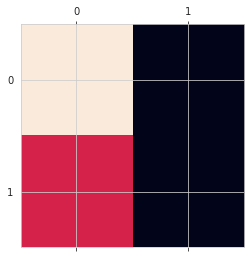

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
plt.matshow(confusion_matrix(y_test, pred_Y>0.43819064))
print(classification_report(y_test, pred_Y>0.43819064, target_names = ['No Mass', 'Mass']))

## **Nodule**

0    12660
1     6331
Name: Nodule, dtype: int64


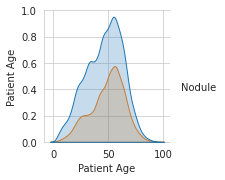

In [5]:
positive_cases = np.sum(all_xray_df['Nodule']==True)//2
oversample_factor = 4 # maximum number of cases in negative group so it isn't super rare
more_balanced_df = all_xray_df.groupby(['Nodule']).apply(lambda x: x.sample(min(oversample_factor*positive_cases, x.shape[0]), 
                                                                                   replace = False)
                                                      ).reset_index(drop = True)

print(more_balanced_df['Nodule'].value_counts())
sns.pairplot(more_balanced_df[['Patient Age', 'Nodule']], hue='Nodule')

In [6]:
from sklearn.model_selection import train_test_split
raw_train_df, test_valid_df = train_test_split(more_balanced_df, 
                                   test_size = 0.30, 
                                   random_state = 2018,
                                   stratify = more_balanced_df[['Nodule']])
valid_df, test_df = train_test_split(test_valid_df, 
                                   test_size = 0.40, 
                                   random_state = 2018,
                                   stratify = test_valid_df[['Nodule']])
print('train', raw_train_df.shape[0], 'validation', valid_df.shape[0], 'test', test_df.shape[0])
print('train', raw_train_df['Nodule'].value_counts())
print('test', test_df['Nodule'].value_counts())
raw_train_df.sample(1)

train 13293 validation 3418 test 2280
train 0    8862
1    4431
Name: Nodule, dtype: int64
test 0    1520
1     760
Name: Nodule, dtype: int64


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],path,Pneumonia,Patient Male,Cardiomegaly,Emphysema,Effusion,Hernia,Nodule,Pneumothorax,Atelectasis,Pleural_Thickening,Mass,Edema,Consolidation,Infiltration,Fibrosis,Nothing
11786,00004832_028.png,Consolidation|Infiltration|Pleural_Thickening,16,4832,32,M,AP,2500,2048,0.168,0.168,/content/drive/MyDrive/Images/image3/00004832_...,False,1.0,0,0,0,0,0,0,0,1,0,0,1,1,0,0


In [7]:
train_df = raw_train_df.groupby(['Nodule']).apply(lambda x: x.sample(60000, replace = True)
                                                      ).reset_index(drop = True)
print('New Data Size:', train_df.shape[0], 'Old Size:', raw_train_df.shape[0])

New Data Size: 120000 Old Size: 13293


In [8]:
from keras.preprocessing.image import ImageDataGenerator
idg = ImageDataGenerator(zoom_range=0.2,
                           fill_mode='nearest',
                           rotation_range=25,  
                           width_shift_range=0.25,  
                           height_shift_range=0.25,  
                           vertical_flip=False, 
                           horizontal_flip=True,
                           shear_range = 0.2,
                           samplewise_center=False, 
                           samplewise_std_normalization=False)


In [9]:
SEED= 10
IMG_SIZE = (128, 128) 
####
def flow_from_dataframe(imgDatGen, df, batch_size, seed, img_size):
    #gc.collect()
    gen_img = imgDatGen.flow_from_dataframe(dataframe=more_balanced_df,
        x_col='path', y_col='Nodule',
        batch_size=batch_size, seed=seed, shuffle=True, class_mode='other',
        target_size=img_size, color_mode='grayscale',
        drop_duplicates=False)

    
        
    while True:
        X1i = gen_img.next()
        #X2i = gen_img.next()
        #gc.collect()
        yield [X1i[0], X1i[1]]

In [10]:
flow = flow_from_dataframe(idg, more_balanced_df, 7151, SEED, IMG_SIZE)

In [11]:
t,y= next(flow)

--- Logging error ---
Traceback (most recent call last):
  File "/usr/lib/python3.7/logging/__init__.py", line 1025, in emit
    msg = self.format(record)
  File "/usr/lib/python3.7/logging/__init__.py", line 869, in format
    return fmt.format(record)
  File "/usr/lib/python3.7/logging/__init__.py", line 608, in format
    record.message = record.getMessage()
  File "/usr/lib/python3.7/logging/__init__.py", line 369, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "/usr/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.7/dist-packages/traitlets/config/application.py", line 846, in launch_instance
    app.start()
  File "/usr/local/lib/pytho

Found 18991 validated image filenames.


In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(t,y, 
                                   test_size = 0.30, 
                                   random_state = 2018)


In [13]:
from keras.applications.mobilenet import MobileNet
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from keras.models import Sequential
mobilenet_model = MobileNet(input_shape =  X_train.shape[1:], 
                                 include_top = False, weights = None)
mobilenet_GAP_model = Sequential()
mobilenet_GAP_model.add(mobilenet_model)
mobilenet_GAP_model.add(GlobalAveragePooling2D())
mobilenet_GAP_model.add(Dropout(0.5))
mobilenet_GAP_model.add(Dense(512))
mobilenet_GAP_model.add(Dropout(0.5))
mobilenet_GAP_model.add(Dense(1, activation = 'sigmoid'))
mobilenet_GAP_model.compile(optimizer = 'adam', loss = 'binary_crossentropy',
                           metrics = ['binary_accuracy', 'mae'])
mobilenet_GAP_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_128 (Functio  (None, 4, 4, 1024)       3228288   
 nal)                                                            
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 512)               524800    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 5

In [14]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=3)
callbacks_list = [checkpoint, early]

In [15]:
history_mobilenet_GAP = mobilenet_GAP_model.fit(X_train,y_train,
                                  steps_per_epoch=10,
                                  validation_data = (X_test, y_test), 
                                  epochs = 10, 
                                  callbacks = callbacks_list)

Epoch 1/10
10/10 [==============================] - ETA: 0s - loss: 1.7284 - binary_accuracy: 0.5762 - mae: 0.4319 
Epoch 00001: val_loss improved from inf to 0.68848, saving model to xray_class_weights.best.hdf5
10/10 [==============================] - 356s 35s/step - loss: 1.7284 - binary_accuracy: 0.5762 - mae: 0.4319 - val_loss: 0.6885 - val_binary_accuracy: 0.6803 - val_mae: 0.4976
Epoch 2/10
10/10 [==============================] - ETA: 0s - loss: 0.9950 - binary_accuracy: 0.5642 - mae: 0.4519 
Epoch 00002: val_loss improved from 0.68848 to 0.68409, saving model to xray_class_weights.best.hdf5
10/10 [==============================] - 330s 33s/step - loss: 0.9950 - binary_accuracy: 0.5642 - mae: 0.4519 - val_loss: 0.6841 - val_binary_accuracy: 0.6803 - val_mae: 0.4953
Epoch 3/10
10/10 [==============================] - ETA: 0s - loss: 0.8248 - binary_accuracy: 0.5746 - mae: 0.4537 
Epoch 00003: val_loss improved from 0.68409 to 0.66215, saving model to xray_class_weights.best.hdf5

In [16]:
pred_Y = mobilenet_GAP_model.predict(X_test, 
                          batch_size = 32, 
                          verbose = True)

68/68 [==============================] - 22s 317ms/step


In [17]:
pred_Y

array([[0.4243728],
       [0.4243728],
       [0.4243728],
       ...,
       [0.4243728],
       [0.4243728],
       [0.4243728]], dtype=float32)

In [18]:
min(pred_Y)

array([0.4243728], dtype=float32)

In [19]:
print('test accuracy = ',mobilenet_GAP_model.evaluate(X_test,y_test, verbose=0)[1])

test accuracy =  0.680335521697998


In [20]:
from sklearn.metrics import roc_auc_score
print('roc score = ',roc_auc_score(y_test.astype(int), pred_Y))

roc score =  0.4980769998801869


              precision    recall  f1-score   support

   No Nodule       0.68      0.99      0.81      1460
      Nodule       0.20      0.00      0.01       686

    accuracy                           0.68      2146
   macro avg       0.44      0.50      0.41      2146
weighted avg       0.53      0.68      0.55      2146



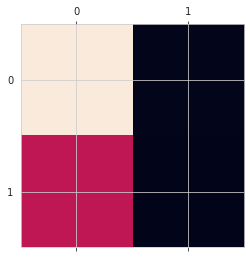

In [21]:
from sklearn.metrics import classification_report, confusion_matrix
plt.matshow(confusion_matrix(y_test, pred_Y>0.4243728))
print(classification_report(y_test, pred_Y>0.4243728, target_names = ['No Nodule', 'Nodule']))

## **Pleural-Thickening**

0    6768
1    3385
Name: Pleural_Thickening, dtype: int64


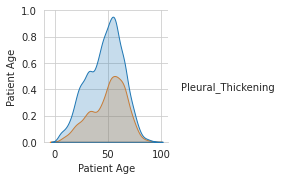

In [22]:
positive_cases = np.sum(all_xray_df['Pleural_Thickening']==True)//2
oversample_factor = 4 # maximum number of cases in negative group so it isn't super rare
more_balanced_df = all_xray_df.groupby(['Pleural_Thickening']).apply(lambda x: x.sample(min(oversample_factor*positive_cases, x.shape[0]), 
                                                                                   replace = False)
                                                      ).reset_index(drop = True)

print(more_balanced_df['Pleural_Thickening'].value_counts())
sns.pairplot(more_balanced_df[['Patient Age', 'Pleural_Thickening']], hue='Pleural_Thickening')

In [23]:
from sklearn.model_selection import train_test_split
raw_train_df, test_valid_df = train_test_split(more_balanced_df, 
                                   test_size = 0.30, 
                                   random_state = 2018,
                                   stratify = more_balanced_df[['Pleural_Thickening']])
valid_df, test_df = train_test_split(test_valid_df, 
                                   test_size = 0.40, 
                                   random_state = 2018,
                                   stratify = test_valid_df[['Pleural_Thickening']])
print('train', raw_train_df.shape[0], 'validation', valid_df.shape[0], 'test', test_df.shape[0])
print('train', raw_train_df['Pleural_Thickening'].value_counts())
print('test', test_df['Pleural_Thickening'].value_counts())
raw_train_df.sample(1)

train 7107 validation 1827 test 1219
train 0    4738
1    2369
Name: Pleural_Thickening, dtype: int64
test 0    812
1    407
Name: Pleural_Thickening, dtype: int64


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],path,Pneumonia,Patient Male,Cardiomegaly,Emphysema,Effusion,Hernia,Nodule,Pneumothorax,Atelectasis,Pleural_Thickening,Mass,Edema,Consolidation,Infiltration,Fibrosis,Nothing
4290,00002457_011.png,No Finding,11,2457,15,M,AP,2500,2048,0.168,0.168,/content/drive/MyDrive/Images/image2/00002457_...,False,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [24]:
train_df = raw_train_df.groupby(['Pleural_Thickening']).apply(lambda x: x.sample(60000, replace = True)
                                                      ).reset_index(drop = True)
print('New Data Size:', train_df.shape[0], 'Old Size:', raw_train_df.shape[0])

New Data Size: 120000 Old Size: 7107


In [25]:
from keras.preprocessing.image import ImageDataGenerator
idg = ImageDataGenerator(zoom_range=0.2,
                           fill_mode='nearest',
                           rotation_range=25,  
                           width_shift_range=0.25,  
                           height_shift_range=0.25,  
                           vertical_flip=False, 
                           horizontal_flip=True,
                           shear_range = 0.2,
                           samplewise_center=False, 
                           samplewise_std_normalization=False)


In [26]:
SEED= 10
IMG_SIZE = (128, 128) 
####
def flow_from_dataframe(imgDatGen, df, batch_size, seed, img_size):
    #gc.collect()
    gen_img = imgDatGen.flow_from_dataframe(dataframe=more_balanced_df,
        x_col='path', y_col='Pleural_Thickening',
        batch_size=batch_size, seed=seed, shuffle=True, class_mode='other',
        target_size=img_size, color_mode='grayscale',
        drop_duplicates=False)

    
        
    while True:
        X1i = gen_img.next()
        #X2i = gen_img.next()
        #gc.collect()
        yield [X1i[0], X1i[1]]

In [27]:
flow = flow_from_dataframe(idg, more_balanced_df, 7151, SEED, IMG_SIZE)

In [28]:
t,y= next(flow)

--- Logging error ---
Traceback (most recent call last):
  File "/usr/lib/python3.7/logging/__init__.py", line 1025, in emit
    msg = self.format(record)
  File "/usr/lib/python3.7/logging/__init__.py", line 869, in format
    return fmt.format(record)
  File "/usr/lib/python3.7/logging/__init__.py", line 608, in format
    record.message = record.getMessage()
  File "/usr/lib/python3.7/logging/__init__.py", line 369, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "/usr/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.7/dist-packages/traitlets/config/application.py", line 846, in launch_instance
    app.start()
  File "/usr/local/lib/pytho

Found 10153 validated image filenames.


In [29]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(t,y, 
                                   test_size = 0.30, 
                                   random_state = 2018)


In [30]:
from keras.applications.mobilenet import MobileNet
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from keras.models import Sequential
mobilenet_model = MobileNet(input_shape =  X_train.shape[1:], 
                                 include_top = False, weights = None)
mobilenet_GAP_model = Sequential()
mobilenet_GAP_model.add(mobilenet_model)
mobilenet_GAP_model.add(GlobalAveragePooling2D())
mobilenet_GAP_model.add(Dropout(0.5))
mobilenet_GAP_model.add(Dense(512))
mobilenet_GAP_model.add(Dropout(0.5))
mobilenet_GAP_model.add(Dense(1, activation = 'sigmoid'))
mobilenet_GAP_model.compile(optimizer = 'adam', loss = 'binary_crossentropy',
                           metrics = ['binary_accuracy', 'mae'])
mobilenet_GAP_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_128 (Functio  (None, 4, 4, 1024)       3228288   
 nal)                                                            
                                                                 
 global_average_pooling2d_1   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_2 (Dropout)         (None, 1024)              0         
                                                                 
 dense_2 (Dense)             (None, 512)               524800    
                                                                 
 dropout_3 (Dropout)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                

In [31]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=3)
callbacks_list = [checkpoint, early]

In [32]:
history_mobilenet_GAP = mobilenet_GAP_model.fit(X_train,y_train,
                                  steps_per_epoch=10,
                                  validation_data = (X_test, y_test), 
                                  epochs = 10, 
                                  callbacks = callbacks_list)

Epoch 1/10
10/10 [==============================] - ETA: 0s - loss: 1.7524 - binary_accuracy: 0.5840 - mae: 0.4202 
Epoch 00001: val_loss improved from inf to 0.67635, saving model to xray_class_weights.best.hdf5
10/10 [==============================] - 347s 34s/step - loss: 1.7524 - binary_accuracy: 0.5840 - mae: 0.4202 - val_loss: 0.6764 - val_binary_accuracy: 0.6598 - val_mae: 0.4908
Epoch 2/10
10/10 [==============================] - ETA: 0s - loss: 0.9813 - binary_accuracy: 0.5604 - mae: 0.4548 
Epoch 00002: val_loss improved from 0.67635 to 0.66491, saving model to xray_class_weights.best.hdf5
10/10 [==============================] - 330s 33s/step - loss: 0.9813 - binary_accuracy: 0.5604 - mae: 0.4548 - val_loss: 0.6649 - val_binary_accuracy: 0.6598 - val_mae: 0.4832
Epoch 3/10
10/10 [==============================] - ETA: 0s - loss: 0.7805 - binary_accuracy: 0.5930 - mae: 0.4459 
Epoch 00003: val_loss improved from 0.66491 to 0.64796, saving model to xray_class_weights.best.hdf5

In [33]:
pred_Y = mobilenet_GAP_model.predict(X_test, 
                          batch_size = 32, 
                          verbose = True)

68/68 [==============================] - 22s 317ms/step


In [34]:
pred_Y

array([[0.25152546],
       [0.25152546],
       [0.25152546],
       ...,
       [0.25152546],
       [0.25152546],
       [0.25152546]], dtype=float32)

In [35]:
min(pred_Y)

array([0.2515254], dtype=float32)

In [36]:
print('test accuracy = ',mobilenet_GAP_model.evaluate(X_test,y_test, verbose=0)[1])

test accuracy =  0.659832239151001


In [37]:
from sklearn.metrics import roc_auc_score
print('roc score = ',roc_auc_score(y_test.astype(int), pred_Y))

roc score =  0.5007274978716818


                       precision    recall  f1-score   support

No Pleural_Thickening       0.80      0.00      0.01      1416
   Pleural_Thickening       0.34      1.00      0.51       730

             accuracy                           0.34      2146
            macro avg       0.57      0.50      0.26      2146
         weighted avg       0.64      0.34      0.18      2146



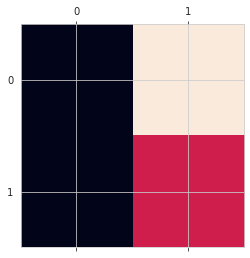

In [38]:
from sklearn.metrics import classification_report, confusion_matrix
plt.matshow(confusion_matrix(y_test, pred_Y>0.2515254))
print(classification_report(y_test, pred_Y>0.2515254, target_names = ['No Pleural_Thickening', 'Pleural_Thickening']))

## **Pneumonia**

False    2860
True     1431
Name: Pneumonia, dtype: int64


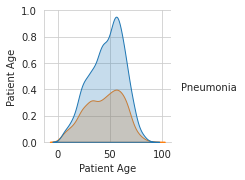

In [39]:
positive_cases = np.sum(all_xray_df['Pneumonia']==True)//2
oversample_factor = 4 # maximum number of cases in negative group so it isn't super rare
more_balanced_df = all_xray_df.groupby(['Pneumonia']).apply(lambda x: x.sample(min(oversample_factor*positive_cases, x.shape[0]), 
                                                                                   replace = False)
                                                      ).reset_index(drop = True)

print(more_balanced_df['Pneumonia'].value_counts())
sns.pairplot(more_balanced_df[['Patient Age', 'Pneumonia']], hue='Pneumonia')

In [40]:
from sklearn.model_selection import train_test_split
raw_train_df, test_valid_df = train_test_split(more_balanced_df, 
                                   test_size = 0.30, 
                                   random_state = 2018,
                                   stratify = more_balanced_df[['Pneumonia']])
valid_df, test_df = train_test_split(test_valid_df, 
                                   test_size = 0.40, 
                                   random_state = 2018,
                                   stratify = test_valid_df[['Pneumonia']])
print('train', raw_train_df.shape[0], 'validation', valid_df.shape[0], 'test', test_df.shape[0])
print('train', raw_train_df['Pneumonia'].value_counts())
print('test', test_df['Pneumonia'].value_counts())
raw_train_df.sample(1)

train 3003 validation 772 test 516
train False    2002
True     1001
Name: Pneumonia, dtype: int64
test False    344
True     172
Name: Pneumonia, dtype: int64


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],path,Pneumonia,Patient Male,Cardiomegaly,Emphysema,Effusion,Hernia,Nodule,Pneumothorax,Atelectasis,Pleural_Thickening,Mass,Edema,Consolidation,Infiltration,Fibrosis,Nothing
1977,00016743_011.png,No Finding,11,16743,57,F,PA,2992,2991,0.143,0.143,/content/drive/MyDrive/Images/image8/00016743_...,False,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [41]:
train_df = raw_train_df.groupby(['Pneumonia']).apply(lambda x: x.sample(60000, replace = True)
                                                      ).reset_index(drop = True)
print('New Data Size:', train_df.shape[0], 'Old Size:', raw_train_df.shape[0])

New Data Size: 120000 Old Size: 3003


In [42]:
from keras.preprocessing.image import ImageDataGenerator
idg = ImageDataGenerator(zoom_range=0.2,
                           fill_mode='nearest',
                           rotation_range=25,  
                           width_shift_range=0.25,  
                           height_shift_range=0.25,  
                           vertical_flip=False, 
                           horizontal_flip=True,
                           shear_range = 0.2,
                           samplewise_center=False, 
                           samplewise_std_normalization=False)


In [43]:
SEED= 10
IMG_SIZE = (128, 128) 
####
def flow_from_dataframe(imgDatGen, df, batch_size, seed, img_size):
    #gc.collect()
    gen_img = imgDatGen.flow_from_dataframe(dataframe=more_balanced_df,
        x_col='path', y_col='Pneumonia',
        batch_size=batch_size, seed=seed, shuffle=True, class_mode='other',
        target_size=img_size, color_mode='grayscale',
        drop_duplicates=False)

    
        
    while True:
        X1i = gen_img.next()
        #X2i = gen_img.next()
        #gc.collect()
        yield [X1i[0], X1i[1]]

In [44]:
flow = flow_from_dataframe(idg, more_balanced_df, 7151, SEED, IMG_SIZE)

In [45]:
t,y= next(flow)

--- Logging error ---
Traceback (most recent call last):
  File "/usr/lib/python3.7/logging/__init__.py", line 1025, in emit
    msg = self.format(record)
  File "/usr/lib/python3.7/logging/__init__.py", line 869, in format
    return fmt.format(record)
  File "/usr/lib/python3.7/logging/__init__.py", line 608, in format
    record.message = record.getMessage()
  File "/usr/lib/python3.7/logging/__init__.py", line 369, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "/usr/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.7/dist-packages/traitlets/config/application.py", line 846, in launch_instance
    app.start()
  File "/usr/local/lib/pytho

Found 4291 validated image filenames.


In [46]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(t,y, 
                                   test_size = 0.30, 
                                   random_state = 2018)


In [47]:
from keras.applications.mobilenet import MobileNet
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from keras.models import Sequential
mobilenet_model = MobileNet(input_shape =  X_train.shape[1:], 
                                 include_top = False, weights = None)
mobilenet_GAP_model = Sequential()
mobilenet_GAP_model.add(mobilenet_model)
mobilenet_GAP_model.add(GlobalAveragePooling2D())
mobilenet_GAP_model.add(Dropout(0.5))
mobilenet_GAP_model.add(Dense(512))
mobilenet_GAP_model.add(Dropout(0.5))
mobilenet_GAP_model.add(Dense(1, activation = 'sigmoid'))
mobilenet_GAP_model.compile(optimizer = 'adam', loss = 'binary_crossentropy',
                           metrics = ['binary_accuracy', 'mae'])
mobilenet_GAP_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_128 (Functio  (None, 4, 4, 1024)       3228288   
 nal)                                                            
                                                                 
 global_average_pooling2d_2   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_4 (Dropout)         (None, 1024)              0         
                                                                 
 dense_4 (Dense)             (None, 512)               524800    
                                                                 
 dropout_5 (Dropout)         (None, 512)               0         
                                                                 
 dense_5 (Dense)             (None, 1)                

In [48]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=3)
callbacks_list = [checkpoint, early]

In [49]:
history_mobilenet_GAP = mobilenet_GAP_model.fit(X_train,y_train,
                                  steps_per_epoch=10,
                                  validation_data = (X_test, y_test), 
                                  epochs = 10, 
                                  callbacks = callbacks_list)

Epoch 1/10
10/10 [==============================] - ETA: 0s - loss: 2.1604 - binary_accuracy: 0.5904 - mae: 0.4175 
Epoch 00001: val_loss improved from inf to 0.70275, saving model to xray_class_weights.best.hdf5
10/10 [==============================] - 200s 20s/step - loss: 2.1604 - binary_accuracy: 0.5904 - mae: 0.4175 - val_loss: 0.7027 - val_binary_accuracy: 0.3261 - val_mae: 0.5046
Epoch 2/10
10/10 [==============================] - ETA: 0s - loss: 1.1301 - binary_accuracy: 0.5528 - mae: 0.4586 
Epoch 00002: val_loss improved from 0.70275 to 0.66343, saving model to xray_class_weights.best.hdf5
10/10 [==============================] - 196s 20s/step - loss: 1.1301 - binary_accuracy: 0.5528 - mae: 0.4586 - val_loss: 0.6634 - val_binary_accuracy: 0.6739 - val_mae: 0.4827
Epoch 3/10
10/10 [==============================] - ETA: 0s - loss: 0.7828 - binary_accuracy: 0.6074 - mae: 0.4514 
Epoch 00003: val_loss improved from 0.66343 to 0.65707, saving model to xray_class_weights.best.hdf5

In [50]:
pred_Y = mobilenet_GAP_model.predict(X_test, 
                          batch_size = 32, 
                          verbose = True)

41/41 [==============================] - 13s 310ms/step


In [51]:
pred_Y

array([[0.22033998],
       [0.22033998],
       [0.22033998],
       ...,
       [0.22033998],
       [0.22033998],
       [0.22033998]], dtype=float32)

In [52]:
min(pred_Y)

array([0.22033998], dtype=float32)

In [53]:
print('test accuracy = ',mobilenet_GAP_model.evaluate(X_test,y_test, verbose=0)[1])

test accuracy =  0.6739130616188049


In [54]:
from sklearn.metrics import roc_auc_score
print('roc score = ',roc_auc_score(y_test.astype(int), pred_Y))

roc score =  0.5


              precision    recall  f1-score   support

No Pneumonia       0.67      1.00      0.81       868
   Pneumonia       0.00      0.00      0.00       420

    accuracy                           0.67      1288
   macro avg       0.34      0.50      0.40      1288
weighted avg       0.45      0.67      0.54      1288



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


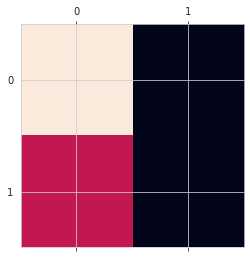

In [55]:
from sklearn.metrics import classification_report, confusion_matrix
plt.matshow(confusion_matrix(y_test, pred_Y>0.22033998))
print(classification_report(y_test, pred_Y>0.22033998, target_names = ['No Pneumonia', 'Pneumonia']))

## **Pneumothorax**

0    10604
1     5302
Name: Pneumothorax, dtype: int64


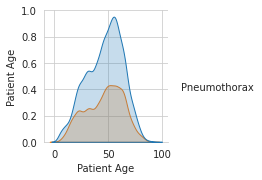

In [56]:
positive_cases = np.sum(all_xray_df['Pneumothorax']==True)//2
oversample_factor = 4 # maximum number of cases in negative group so it isn't super rare
more_balanced_df = all_xray_df.groupby(['Pneumothorax']).apply(lambda x: x.sample(min(oversample_factor*positive_cases, x.shape[0]), 
                                                                                   replace = False)
                                                      ).reset_index(drop = True)

print(more_balanced_df['Pneumothorax'].value_counts())
sns.pairplot(more_balanced_df[['Patient Age', 'Pneumothorax']], hue='Pneumothorax')

In [57]:
from sklearn.model_selection import train_test_split
raw_train_df, test_valid_df = train_test_split(more_balanced_df, 
                                   test_size = 0.30, 
                                   random_state = 2018,
                                   stratify = more_balanced_df[['Pneumothorax']])
valid_df, test_df = train_test_split(test_valid_df, 
                                   test_size = 0.40, 
                                   random_state = 2018,
                                   stratify = test_valid_df[['Pneumothorax']])
print('train', raw_train_df.shape[0], 'validation', valid_df.shape[0], 'test', test_df.shape[0])
print('train', raw_train_df['Pneumothorax'].value_counts())
print('test', test_df['Pneumothorax'].value_counts())
raw_train_df.sample(1)

train 11134 validation 2863 test 1909
train 0    7423
1    3711
Name: Pneumothorax, dtype: int64
test 0    1273
1     636
Name: Pneumothorax, dtype: int64


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],path,Pneumonia,Patient Male,Cardiomegaly,Emphysema,Effusion,Hernia,Nodule,Pneumothorax,Atelectasis,Pleural_Thickening,Mass,Edema,Consolidation,Infiltration,Fibrosis,Nothing
639,00009052_000.png,No Finding,0,9052,42,M,PA,2750,2585,0.143,0.143,/content/drive/MyDrive/Images/image4/00009052_...,False,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [58]:
train_df = raw_train_df.groupby(['Pneumothorax']).apply(lambda x: x.sample(60000, replace = True)
                                                      ).reset_index(drop = True)
print('New Data Size:', train_df.shape[0], 'Old Size:', raw_train_df.shape[0])

New Data Size: 120000 Old Size: 11134


In [59]:
from keras.preprocessing.image import ImageDataGenerator
idg = ImageDataGenerator(zoom_range=0.2,
                           fill_mode='nearest',
                           rotation_range=25,  
                           width_shift_range=0.25,  
                           height_shift_range=0.25,  
                           vertical_flip=False, 
                           horizontal_flip=True,
                           shear_range = 0.2,
                           samplewise_center=False, 
                           samplewise_std_normalization=False)


In [60]:
SEED= 10
IMG_SIZE = (128, 128) 
####
def flow_from_dataframe(imgDatGen, df, batch_size, seed, img_size):
    #gc.collect()
    gen_img = imgDatGen.flow_from_dataframe(dataframe=more_balanced_df,
        x_col='path', y_col='Pneumothorax',
        batch_size=batch_size, seed=seed, shuffle=True, class_mode='other',
        target_size=img_size, color_mode='grayscale',
        drop_duplicates=False)

    
        
    while True:
        X1i = gen_img.next()
        #X2i = gen_img.next()
        #gc.collect()
        yield [X1i[0], X1i[1]]

In [61]:
flow = flow_from_dataframe(idg, more_balanced_df, 7151, SEED, IMG_SIZE)

In [62]:
t,y= next(flow)

--- Logging error ---
Traceback (most recent call last):
  File "/usr/lib/python3.7/logging/__init__.py", line 1025, in emit
    msg = self.format(record)
  File "/usr/lib/python3.7/logging/__init__.py", line 869, in format
    return fmt.format(record)
  File "/usr/lib/python3.7/logging/__init__.py", line 608, in format
    record.message = record.getMessage()
  File "/usr/lib/python3.7/logging/__init__.py", line 369, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "/usr/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.7/dist-packages/traitlets/config/application.py", line 846, in launch_instance
    app.start()
  File "/usr/local/lib/pytho

Found 15906 validated image filenames.


In [63]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(t,y, 
                                   test_size = 0.30, 
                                   random_state = 2018)


In [64]:
from keras.applications.mobilenet import MobileNet
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from keras.models import Sequential
mobilenet_model = MobileNet(input_shape =  X_train.shape[1:], 
                                 include_top = False, weights = None)
mobilenet_GAP_model = Sequential()
mobilenet_GAP_model.add(mobilenet_model)
mobilenet_GAP_model.add(GlobalAveragePooling2D())
mobilenet_GAP_model.add(Dropout(0.5))
mobilenet_GAP_model.add(Dense(512))
mobilenet_GAP_model.add(Dropout(0.5))
mobilenet_GAP_model.add(Dense(1, activation = 'sigmoid'))
mobilenet_GAP_model.compile(optimizer = 'adam', loss = 'binary_crossentropy',
                           metrics = ['binary_accuracy', 'mae'])
mobilenet_GAP_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_128 (Functio  (None, 4, 4, 1024)       3228288   
 nal)                                                            
                                                                 
 global_average_pooling2d_3   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_6 (Dropout)         (None, 1024)              0         
                                                                 
 dense_6 (Dense)             (None, 512)               524800    
                                                                 
 dropout_7 (Dropout)         (None, 512)               0         
                                                                 
 dense_7 (Dense)             (None, 1)                

In [65]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=3)
callbacks_list = [checkpoint, early]

In [66]:
history_mobilenet_GAP = mobilenet_GAP_model.fit(X_train,y_train,
                                  steps_per_epoch=10,
                                  validation_data = (X_test, y_test), 
                                  epochs = 10, 
                                  callbacks = callbacks_list)

Epoch 1/10
10/10 [==============================] - ETA: 0s - loss: 1.5284 - binary_accuracy: 0.5854 - mae: 0.4219 
Epoch 00001: val_loss improved from inf to 0.69356, saving model to xray_class_weights.best.hdf5
10/10 [==============================] - 333s 33s/step - loss: 1.5284 - binary_accuracy: 0.5854 - mae: 0.4219 - val_loss: 0.6936 - val_binary_accuracy: 0.3262 - val_mae: 0.5002
Epoch 2/10
10/10 [==============================] - ETA: 0s - loss: 0.8864 - binary_accuracy: 0.5710 - mae: 0.4470 
Epoch 00002: val_loss did not improve from 0.69356
10/10 [==============================] - 331s 33s/step - loss: 0.8864 - binary_accuracy: 0.5710 - mae: 0.4470 - val_loss: 0.7012 - val_binary_accuracy: 0.3262 - val_mae: 0.5039
Epoch 3/10
10/10 [==============================] - ETA: 0s - loss: 0.7636 - binary_accuracy: 0.6088 - mae: 0.4373 
Epoch 00003: val_loss improved from 0.69356 to 0.67926, saving model to xray_class_weights.best.hdf5
10/10 [==============================] - 323s 33s

In [67]:
pred_Y = mobilenet_GAP_model.predict(X_test, 
                          batch_size = 32, 
                          verbose = True)

68/68 [==============================] - 22s 314ms/step


In [68]:
pred_Y

array([[0.48952264],
       [0.48952264],
       [0.48952264],
       ...,
       [0.48952264],
       [0.48952264],
       [0.48952264]], dtype=float32)

In [69]:
min(pred_Y)

array([0.48952264], dtype=float32)

In [70]:
print('test accuracy = ',mobilenet_GAP_model.evaluate(X_test,y_test, verbose=0)[1])

test accuracy =  0.6738117337226868


In [71]:
from sklearn.metrics import roc_auc_score
print('roc score = ',roc_auc_score(y_test.astype(int), pred_Y))

roc score =  0.4993766054139498


                 precision    recall  f1-score   support

No Pneumothorax       0.67      0.99      0.80      1446
   Pneumothorax       0.27      0.00      0.01       700

       accuracy                           0.67      2146
      macro avg       0.47      0.50      0.41      2146
   weighted avg       0.54      0.67      0.54      2146



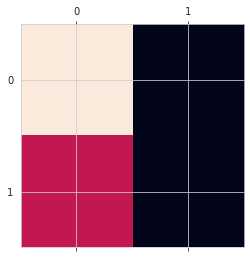

In [72]:
from sklearn.metrics import classification_report, confusion_matrix
plt.matshow(confusion_matrix(y_test, pred_Y>0.48952264))
print(classification_report(y_test, pred_Y>0.48952264, target_names = ['No Pneumothorax', 'Pneumothorax']))